<center><h5> Data Science For Suppy Chain & Operations </h5></center>
<center><h1> Création d'un data set, exploration des données, data cleaning & feature engineering </h1></center>

* Après les premiers travaux d'idéation et d'analyse de l'opportunité, vient une étape clé de toute démarche Data Science : **la création et la préparation d'un jeu de données exploitable**
* Elle consiste à définir et collecter les données d'intérêts, et réaliser des premières analyses permettant d'identifier les corrections à faire *(traitement des valeurs manquantes, des valeurs abérrantes,...)*, et les agrégations possibles entre les différentes sources données
* Lors de cette étape, des premières explorations statistiques sont réalisées, et permettent au Data Scientist de raffiner sa compréhension de la problématique et de mieux cadrer les pistes à explorer pour y répondre. Ces explorations consistent notamment à étudier les distributions des différentes variables, les relations et dépendances entre celles-ci, etc.
* Ces premières analyses vont également permettre d'identifier de nouvelles variables à créer *(à partir des données disponibles ou de nouvelles sources externes)*, on parle de **Feature Engineering** 
* Lors de la réalisation de ces travaux, des bonnes pratiques sont à appliquer rigoureusement : *sanity checks* à faire après chaque traitement, *packaging* des transformations dans des fonctions unitaires réutilisables, ...

# 0. Chargement des librairies et des données fournies

In [1]:
import numpy as np
import pandas as pd
## On peut choisir le nombre max de lignes/colonnes à voir
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
pd.options.display.float_format = '{:,.2f}'.format

import datetime

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter
import seaborn as sns
sns.set(color_codes = True)
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Remplir par le bon chemin vers le fichier contenant les données csv ##
path_to_data = "data/"
#########################################################################

## Lecture du fichier train.csv
train = pd.read_csv(path_to_data + "train.csv", 
                    low_memory = False,
                    parse_dates = ["Date"])

## Lecture du fichier store.csv
store = pd.read_csv(path_to_data + "store.csv",
                    low_memory = False)

# 1. Premières explorations des données

In [3]:
## Le fichier train
print(train.shape)
train.head(3)

(1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


Pour rappel, voici la descritpion des colonnes du fichier **train** :
- **`Store`** - un identifiant unique pour chaque magasin <br/>
- **`DayOfWeek`** - indique le jour de la semaine pour cette observation (cette ligne). Lundi:1, dimanche:7 <br/>
- **`Date`** - date de l'observation. Visiblement au format yyyy-mm-dd <br/>
- **`Sales`** - montant des ventes pour le magasin 'Store', pour le jour 'Date' <br/>
- **`Customers`** - nombre de clients <br/>
- **`Open`** - indique si le magasin était ouvert : 0 = fermé, 1 = ouvert <br/>
- **`Promo`** - indique si le magasin 'Store' propose une promotion, pour le jour 'Date'. 0 = pas de promo, 1 = promo <br/>
- **`StateHoliday`** - Indique un jour férié. Normalement, tous les magasins, à quelques exceptions près, sont fermés les jours fériés. Notez que toutes les écoles sont fermées les jours fériés et les week-ends. a = jour férié, b = vacances de Pâques, c = Noël, 0 = aucun
- **`SchoolHoliday`** - Indique si le (magasin, date) a été affecté par la fermeture des écoles publiques

In [4]:
print(store.shape)
store.head(3)

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,"1,270.00",9.00,"2,008.00",0,nan,nan,NaN
1,2,a,a,570.00,11.00,"2,007.00",1,13.00,"2,010.00","Jan,Apr,Jul,Oct"
2,3,a,a,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00","Jan,Apr,Jul,Oct"


Pour rappel, voici la descritpion des colonnes du fichier **store** :
- **`Store`** - un identifiant unique pour chaque magasin <br/>
- **`StoreType`** - Différencie 4 types de magasins différents: a, b, c, d <br/>
- **`Assortment`** - Décrit un niveau d'assortiment: a = basique, b = extra, c = étendu <br/>
- **`CompetitionDistance`** - Distance en mètres du magasin concurrent le plus proche <br/>
- **`CompetitionOpenSince[Month/Year]`** - Indique le mois / l’année approximatifs de l'ouverture du concurrent le plus proche <br/>
- **`Promo2`** - Promo2 est un type de promotion continue et consécutive pour certains magasins: 0 = le magasin ne participe pas, 1 = le magasin participe <br/>
- **`Promo2Since[Year/Week]`** - Décrit la semaine civile / l’année auxquels le magasin a commencé à participer à Promo2 <br/>
- **`PromoInterval`** - Décrit les intervalles consécutifs de démarrage de Promo2, en nommant les mois de redémarrage de la promotion. Par exemple. "Feb,May,Aug,Nov" signifie que chaque cycle commence en février, mai, août et novembre d'une année donnée pour ce magasin

> <font color='blue'>**Que peut-on dire sur le contenu de ces deux fichiers ? Quelle serait la variable <u>Cible</u> (Target) qu'on cherchera à prédire dans les travaux ultérieurs de modélisation ? Peut-on effectuer une jointure de ces deux fichiers en une seule table ?**</font>

- Le fichier **train** est un historique des ventes des magasins. Il est à la maille (magasin, date), i.e. chaque ligne correspond aux données d'un magasin pour une date donnée. Le fichier contient des données descriptives du couple (magasin, date) *(magasin ouvert ou non, promo ou non, ...)*, ainsi que la variable **Sales**, qui sera notre variable cible.

- Le fichier **store** contient des informations descriptives additionnelles sur les magasins, qui ne dépondent pas de la date du jour.

- On peut envisager de joindre les deux tables en une seule, en utilisant la variable **Store** (Id du magasin) comme clé de jointure.

**Avant de joindre les deux fichiers en une seule table, collecter les informations suivantes des deux fichiers *train* et *store* :**
<font color='blue'>
> - **Dans le fichier *train*, combien de magasins sont décrits ? L'historique couvre quelle période ?**
- **Dans le fichier *store*, combien de magasins sont décrits ?**
- **Est-ce qu'on retrouve les mêmes magasins (mêmes Id) dans les deux fichiers ?**
- **Est-ce qu'il y a des valeurs manquantes dans ces deux fichiers ? Si oui, quelles règles peut-on utiliser pour y remédier ?**
</font>

In [5]:
magasin_train = train["Store"].unique()
debut = train["Date"].min()
fin = train["Date"].max()

print(f"Le fichier 'Train' contient des observations sur {len(magasin_train)} magasins différents.")
print("L'historique va du {} au {}".format(debut.date(), fin.date()))

Le fichier 'Train' contient des observations sur 1115 magasins différents.
L'historique va du 2013-01-01 au 2015-07-31


In [6]:
magasin_store = train["Store"].unique()

print(f"Le fichier 'Store' contient des observations sur {len(magasin_store)} magasins différents.")

Le fichier 'Store' contient des observations sur 1115 magasins différents.


In [7]:
rate_magasins_both = len(set(magasin_train) & set(magasin_store)) / len(magasin_train)

print("{} % des magasins du fichier Train sont également dans le fichier Store".format(100 * rate_magasins_both))

100.0 % des magasins du fichier Train sont également dans le fichier Store


Pour la **recherche de valeurs manquantes**, on peut utiliser directement la méthode *info()* de l'objet DataFrame de Pandas. On obtient la réponse à cette question (sur les valeurs manquantes), mais l'*output* n'est pas le plus *user-friendly*...

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


>> <font color='blue'>**Implémenter une fonction qui prend en entrée un DataFrame, et renvoie un DataFrame contenant le nombre et le % des valeurs manquantes pour chacune des colonnes du DataFrame d'entrée. Les variables doivent être classées par ordre décroissant du nombre de valeurs manquantes.**
</font>

In [9]:
def get_missing_values(df):
    """
    Compute number and % of missing values for each column of input data frame, and return result in a data frame
    with columns 'Variable', 'Nombre de valeurs manquantes', '% de valeurs manquantes'. 
    Return data frame is sorted on 'Nombre de valeurs manquantes' (decreasing).
    
    Args:
        df : pandas data frame
    
    Return:
        data frame
    """
    number_missing = df.isna().sum()
    pct_missing = 100 * np.round(number_missing / len(df), 2)
    
    res = pd.DataFrame([number_missing, pct_missing]).T.reset_index()
    res = res.rename(columns = {"index":"Variable", 0:"Nombre de valeurs manquantes", 1: "% de valeurs manquantes"})
    res = res.sort_values(by = "Nombre de valeurs manquantes", ascending=False)
    
    return res

In [10]:
get_missing_values(train)

,Variable,Nombre de valeurs manquantes,% de valeurs manquantes
0,Store,0.00,0.00
1,DayOfWeek,0.00,0.00
2,Date,0.00,0.00
3,Sales,0.00,0.00
4,Customers,0.00,0.00
5,Open,0.00,0.00
6,Promo,0.00,0.00
7,StateHoliday,0.00,0.00
8,SchoolHoliday,0.00,0.00


In [11]:
get_missing_values(store)

,Variable,Nombre de valeurs manquantes,% de valeurs manquantes
7,Promo2SinceWeek,544.00,49.00
8,Promo2SinceYear,544.00,49.00
9,PromoInterval,544.00,49.00
4,CompetitionOpenSinceMonth,354.00,32.00
5,CompetitionOpenSinceYear,354.00,32.00
3,CompetitionDistance,3.00,0.00
0,Store,0.00,0.00
1,StoreType,0.00,0.00
2,Assortment,0.00,0.00
6,Promo2,0.00,0.00


> <font color='blue'>**Que peut-on dire sur les valeurs manquantes dans le fichier Train ?**
</font>

**Le fichier Train ne contient pas de valeurs manquantes.**

> <font color='blue'>**Dans le fichier Store, les colonnes "Promo2SinceWeek", "Promo2SinceYear" et "PromoInterval" contiennent ~50% de valeurs manquantes. On peut penser que c'est justifié par le fait qu'il s'agit de magasins qui ne participent pas à Promo2. Est-ce qu'on peut considérer que cette hypothèse est valide ?.**
</font>

In [12]:
## Vérifier dans un premier temps qu'il s'agit des mêmes magasins pour lesquels ces valeurs sont manquantes
all_promo2_null = store[
    (store["Promo2SinceWeek"].isna())
    & (store["Promo2SinceYear"].isna())
    & (store["PromoInterval"].isna())
]
print(len(all_promo2_null))

544


In [13]:
## Vérifier s'il s'agit de magasins qui ne participent pas à Promo2
all_promo2_null["Promo2"].value_counts()

0    544
Name: Promo2, dtype: int64

Pour les magasins avec des valeurs manquantes dans les colonnes "Promo2Since..." et "PromoInterval", **les données sont en phase avec l'hypothèse formulée : il s'agit de magasins qui ne participent pas à Promo2.**

> <font color='blue'>**Remplacez les valeurs manquantes dans les colonnes "Promo2Since..." et "PromoInterval" par la valeur 0.**
</font>

In [14]:
promo2_cols = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]
store[promo2_cols] = store[promo2_cols].fillna(value=0)

> <font color='blue'>**Dans le fichier Store, les colonnes "CompetitionOpenSinceMonth" et "CompetitionOpenSinceYear" contiennent ~32% de valeurs manquantes. On peut penser que c'est justifié par l'absence de concurrents pour ces magasins. Est-ce qu'on peut considérer que cette hypothèse est valide ?**
</font>

In [16]:
## Vérifier dans un premier temps qu'il s'agit des mêmes magasins pour lesquels ces valeurs sont manquantes
all_competition_null = store[
    (store["CompetitionOpenSinceMonth"].isna())
    & (store["CompetitionOpenSinceYear"].isna())
]
print(len(all_competition_null))

354


In [17]:
## Vérifier s'il s'agit de magasins qui ne participent pas à Promo2
len(all_competition_null[all_competition_null["CompetitionDistance"]==0])

0

Pour les magasins avec des valeurs manquantes dans les colonnes "CompetitionOpenSinceMonth/Year", la colonne "CompetitionDistance" **indique la présence d'un concurrent. On ne peut donc pas valider l'hypothèse initiale.**

Il s'agit donc de valeurs réellement manquantes *(l'entreprise ne dispose pas de ces informations pour ces magasins, les informations ont été mal saisies, ...)*.

> <font color='blue'>**Remplacez les valeurs manquantes dans les colonnes "CompetitionOpenSince..." par la valeur 0.**<br><br>
*Remarque : On choisit de remplacer par la valeur non significative 0 mais on peut remplacer ces valeurs manquantes par d'autres valeurs. **Le plus important c'est d'en tenir compte lors des prochains traitement qui porteront ou utiliseront ces colonnes**.*
</font>

In [18]:
competition_cols = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]
store[competition_cols] = store[competition_cols].fillna(value=0)

> <font color='blue'>**Dans le fichier Store, la colonne "CompetitionDistance" contient 3 valeurs manquantes. Comment peut-on remplacer ces valeurs manquantes ?**<br><br>
*Calculez notamment les valeurs, min, max, moyenne et médianne de cette variable.*
</font>

In [19]:
print("Valeur min de 'CompetitionDistance' : {} m".format(np.round(store["CompetitionDistance"].min(), 2)))
print("Valeur max de 'CompetitionDistance' : {} m".format(np.round(store["CompetitionDistance"].max(), 2)))

## La moyenne de CompetitionDistance ?
print("Valeur moyenne de 'CompetitionDistance' : {} m".format(np.round(store["CompetitionDistance"].mean(), 2)))

## La mediane de CompetitionDistance ?
print("Valeur médiane de 'CompetitionDistance' : {} m".format(np.round(store["CompetitionDistance"].median(), 2)))

Valeur min de 'CompetitionDistance' : 20.0 m
Valeur max de 'CompetitionDistance' : 75860.0 m
Valeur moyenne de 'CompetitionDistance' : 5404.9 m
Valeur médiane de 'CompetitionDistance' : 2325.0 m


In [21]:
## Remplacer les valeurs manquantes par une statistique parmi les précédentes
store["CompetitionDistance"] = store["CompetitionDistance"].fillna(value = store["CompetitionDistance"].median())

<font color='dark'>**Remarque :** </font> En fonction des besoins, il peut être utile d'ajouter pour chaque variable du data set, une nouvelle colonne qui indique si la valeur de cette variable est celle qui figure dans le jeu de données originale ou s'il s'agit d'une valeur modifiée/remplacée/...


> <font color='blue'>**Réalisez une jointure des fichiers Train et Store, pour inclure les infos descriptives de chaque magasins dans l'historique des ventes.**
</font>

In [22]:
print("Dimension du fichier Train : {}".format(train.shape))
print("Dimension du fichier Store : {}".format(store.shape))

## Jointure
df = train.merge(store, how="left", on="Store")
print("Dimension de la table après jointure : {}".format(df.shape))

Dimension du fichier Train : (1017209, 9)
Dimension du fichier Store : (1115, 10)
Dimension de la table après jointure : (1017209, 18)


In [ ]:
## Réordonner les colonnes pour faciliter la lecture
cols_order = [
    "Store",
    "StoreType",
    "Assortment",
    "CompetitionDistance",
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Promo2",
    "Promo2SinceWeek",
    "Promo2SinceYear",
    "PromoInterval",
    "Date",
    "DayOfWeek",
    "Open",
    "Promo",
    "StateHoliday",
    "SchoolHoliday",
    "Customers",
    "Sales"    
]

df = df[cols_order]

In [23]:
df.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,"1,270.00",9.00,"2,008.00",0,0.00,0.00,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,"2,007.00",1,13.00,"2,010.00","Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,"14,130.00",12.00,"2,006.00",1,14.00,"2,011.00","Jan,Apr,Jul,Oct"


In [24]:
get_missing_values(df)

,Variable,Nombre de valeurs manquantes,% de valeurs manquantes
0,Store,0.00,0.00
1,DayOfWeek,0.00,0.00
16,Promo2SinceYear,0.00,0.00
15,Promo2SinceWeek,0.00,0.00
14,Promo2,0.00,0.00
13,CompetitionOpenSinceYear,0.00,0.00
12,CompetitionOpenSinceMonth,0.00,0.00
11,CompetitionDistance,0.00,0.00
10,Assortment,0.00,0.00
9,StoreType,0.00,0.00


# 2. Analyse des variables

- Pour la suite, nous réaliserons des **analyses statistiques** sur les différentes variables du jeu de données afin de raffiner la compréhension du contexte et des objectifs à atteindre.
- Dans un premier temps, chaque variable sera étudiée de façon unitaire : cette **analyse univariée** permet de mieux comprendre les données, d'identifier des valeurs potentiellement aberrantes, et de tirer des premières conclusions sur la suite des travaux
- Des **analyses multivariées** permettront ensuite d'identifier de nouveaux insights, et de définir de nouvelles variables à créer pour enrichir le jeu de données

## 2.1 Analyses univariées

### *Variables numériques*

> <font color='blue'>**Calculer des statistiques descriptives (moyenne, std, ...) de la variable cible 'Sales' et afficher sa distribution. Peut-on en tirer des premiers insights** *(répartition des données, la présence de valeurs aberrantes, ...)* **?**
</font>

In [25]:
## En utilisant la méthode describe()
df["Sales"].describe()

count   1,017,209.00
mean        5,773.82
std         3,849.93
min             0.00
25%         3,727.00
50%         5,744.00
75%         7,856.00
max        41,551.00
Name: Sales, dtype: float64

>> <font color='blue'>**Pour l'affichage de la distribution, implémentez une fonction réutilisable permettant d'afficher l'histogramme et le boxplot de la variable étudiée.**
</font>

In [26]:
def show_distribution(df, var, n_bins=50, stat="count"):
    """
    Args:
        df : data frame
        var : nom de la colonne de df, pour laquelle on souhaite afficher les graphes de distribution
        n_bins : nombre de bins (barres verticales) dans l'histogramme
        stat : "frequency", "count", "density", or "probability", pour l'histogramme
    Return:
        None
    """
    ## Calcul de statistiques pour les afficher sur l'histogramme en barres verticales
    mean_val = df[var].mean()
    med_val = df[var].median()
    mode_val = df[var].mode()[0]     ## La valeur la plus fréquente
    max_val = df[var].max()

    # Une figure pour 2 subplots : 2 ligne, 1 colonne. Subplot 1 sera un histogramme, subplot 2 un box plot
    fig, ax = plt.subplots(2, 1, figsize = (15,10))

    # Plot histogram   
    sns.histplot(
        data = df,
        x=var, 
        bins=n_bins,
        stat = stat,
        ax = ax[0]
    )

    # Ajouter des lignes verticales pour la moyenne, la mediane, mode, et la valeur max
    ax[0].axvline(x=mean_val, color = 'green', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mode_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'black', linestyle='dashed', linewidth = 2)

    # boxplot   
    sns.boxplot(
        x=df[var], 
        ax= ax[1]
    )
    ax[1].set_xlabel(var + 'Value')

    # Ajouter un titre
    fig.suptitle('Distribution de la variable ' + var)

    # Show the figure
    fig.show()

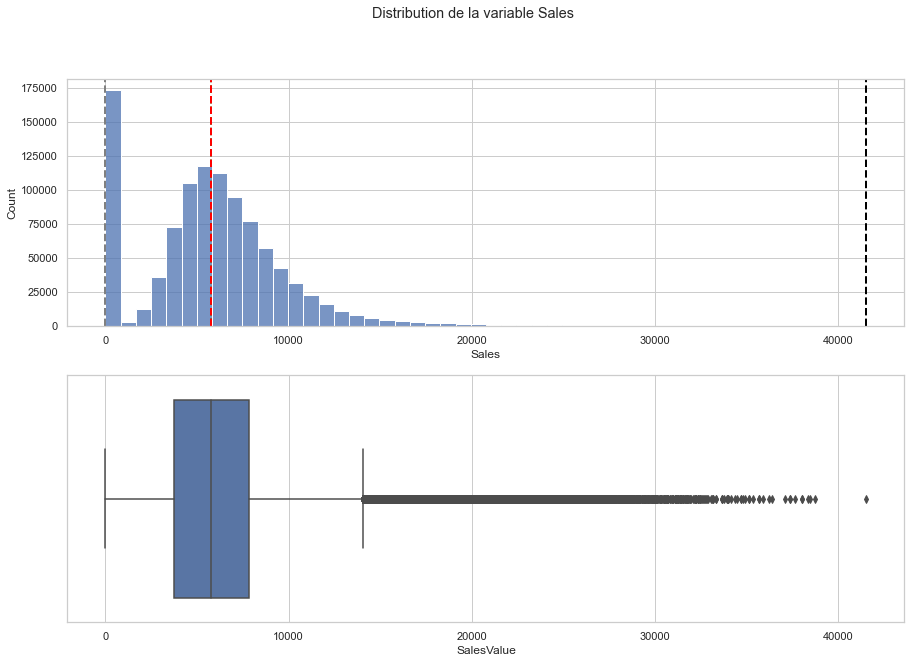

In [27]:
show_distribution(df, "Sales", 50)

- La valeur 0 est la plus fréquente. Celle-ci correspondrait aux jours où le magasin est fermé. Si cette hypothèse est valide, ces observations pourraient être supprimées du jeu de données lors des phases de modélisation.
- Pour les ventes non nulles, la distribution présente une légère asymétrie positive (*positive skeweness*, i.e. la distribution est légérement décalée à gauche de la médiane, avec une queue de distribution étalée vers la droite). Une log-normalization pourrait être intéressante à investiguer pour normaliser la distribution.
- La majorité des valeurs se situent entre 0 et ~14,500. La valeur maximale est de 41.5k. Les valeurs de ventes supérieures au seuil de 14.5k pourrait être des valeurs aberrantes, comme il pourrait s'agir simplement de certains cas où *business was good !*. A ce stade, on n'a pas suffisamment d'information pour conclure.

In [29]:
## Ventes à 0 et ouverture des magasins
df[df["Sales"]==0]["Open"].value_counts()

0    172817
1        54
Name: Open, dtype: int64

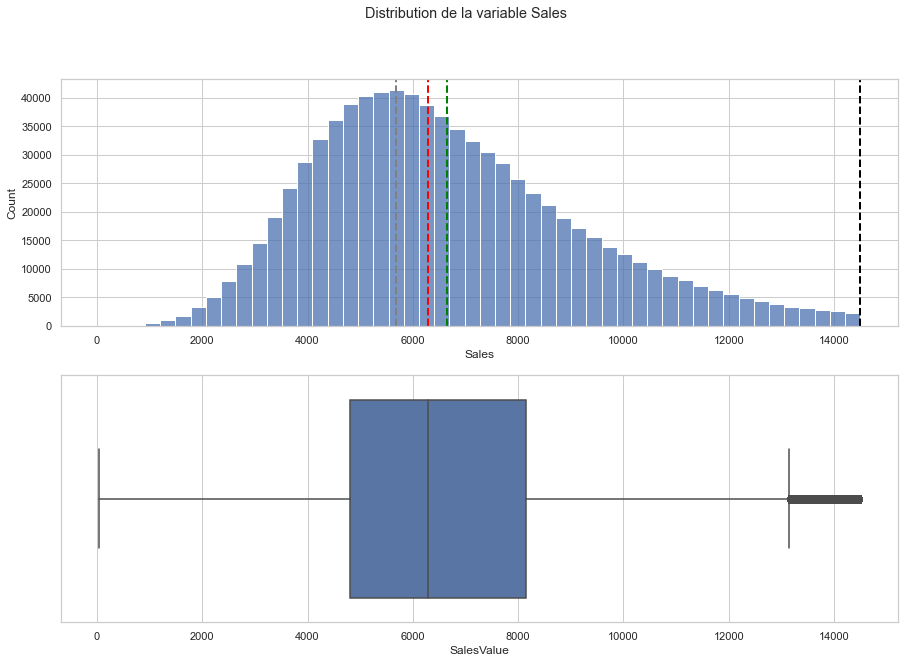

In [30]:
## Distribution entre 0 et 14.5k
sales_filtered = df[(df["Sales"]>0) & (df["Sales"]<14500)]
show_distribution(sales_filtered, "Sales")

> <font color='blue'>**Calculer des statistiques descriptives (moyenne, std, ...) de la variable 'Customers'. Quelle(s) variables peut-on créer à partir de l'analyse de ces premières variables (Sales et Customers) et qui apporterait une caractérisation additionnelle des magasins ?**
</font>

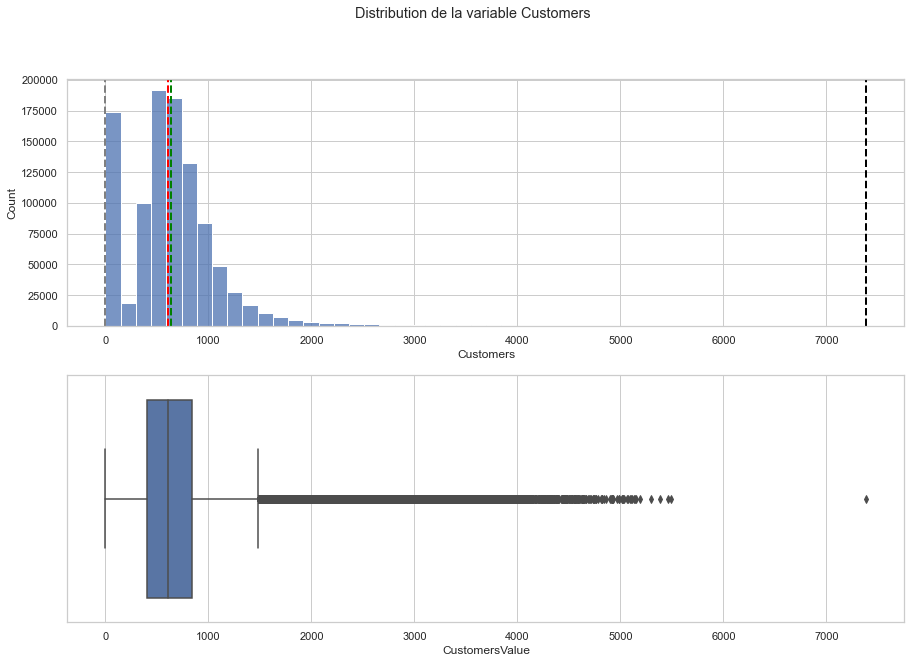

In [31]:
show_distribution(df, "Customers")

On peut s'intéresser à la variable **"Sales / Customers"**, qui reflètera le panier moyen des magasins. Cette variable apportera une information additionnelle pour caractériser les différents magasins, en plus de leurs ventes et leurs nombres de clients : avec les deux variables originales, on pouvait identifier les magasins avec beaucoup/peu de ventes/clients. Avec la nouvelle variable, on peut par exemple caractériser les magasins de la façon suivante : magasin avec beaucoup de clients qui consomment beaucoup, avec beaucoup de clients qui consomment peu, ...

In [32]:
df["Avg_Sales_Per_Customer"] = df["Sales"] / df["Customers"]

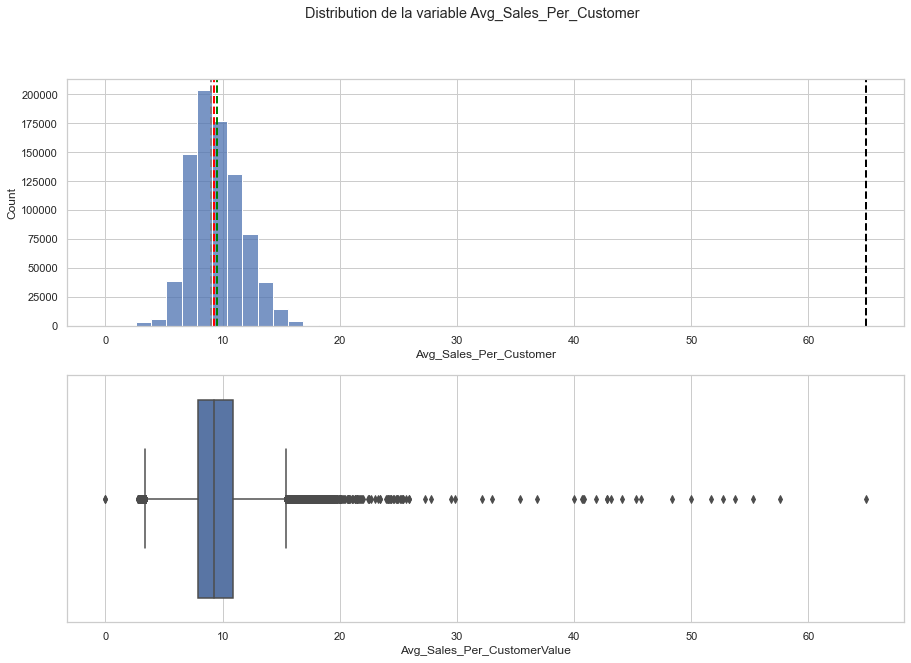

In [33]:
show_distribution(df, "Avg_Sales_Per_Customer")

> <font color='blue'>**Quelle est la distribution de la variable 'CompetitionDistance' sur l'ensemble des observations ?**
</font>

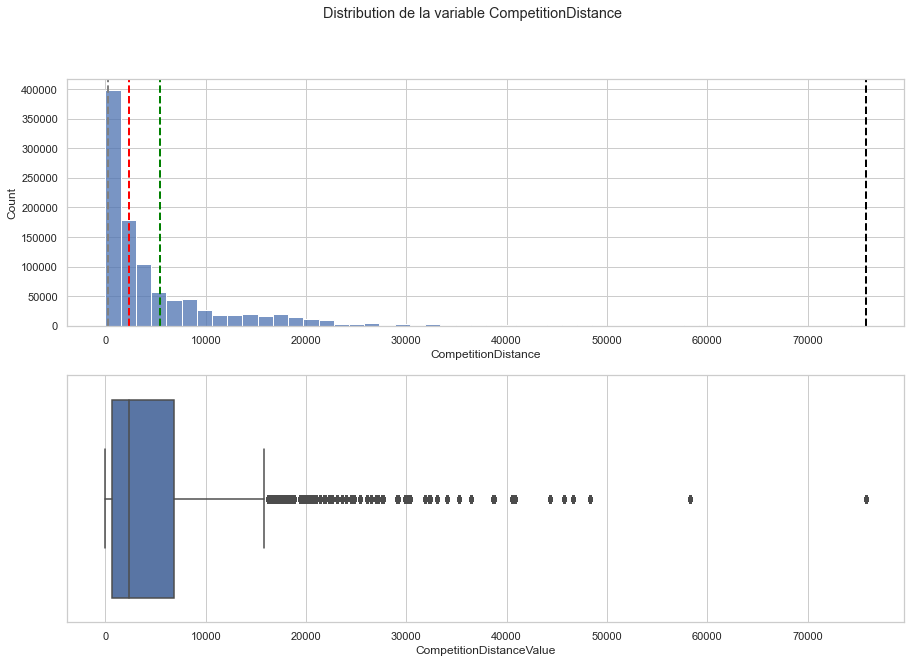

In [34]:
show_distribution(df, "CompetitionDistance")

### *Variables catégorielles*

> <font color='blue'>**Quelles est la répartition des StoreType dans les observations de notre jeu de données ? Implémentez une fonction qui affiche le résultat sous forme de *bar plot*. Réutilisez cette fonction pour le reste des variable catégorielles du jeu de données.**<br><br>
*Ces premières explorations (distributions) permettent de mieux connaitre le jeu de données (combien d'observations concernant des magasins de type X, des assortiments Y, ...). Cela permet ensuite de mieux interpréter les résultats des analyses multivariées et d'anticiper et corriger des potentielles faiblesses des modèles qui seraient dues aux distributions des variables.*
</font>

In [35]:
## StoreType
df["StoreType"].value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

In [36]:
def show_counts(df, var, order=True, group=None, palette="Blues", figsize=(15,5)): 
    """
    Args:
        df : data frame
        var : nom de la colonne de df, pour laquelle on souhaite afficher le nombre d'occurences par modalité
        order : Bool, si True, classer de façon décroissante, sinon, classer par ordre alphabétique du nom des catégories
        group : optionnel, nom d'une autre colonne catégorielle du data frame pour afficher le count selon plusieurs
                de la variable par les catégories de la variable group.
    Return:
        None
    """
    fig, ax = plt.subplots(1, figsize=figsize)

    if order:
        ordered_list = df[var].value_counts().index
    else:
        # sort alpabetically
        ordered_list = sorted(df[var].unique().tolist())
        
    sns.countplot(
        data = df, 
        x = var,
        order = ordered_list,
        hue = group,
        palette = palette,
        ax = ax
    )

    # Afficher le % sur le bar plot pour chaque catégorie
    for j in range(len(ax.patches)):
        p = ax.patches[j]
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(np.round(100*height/len(df), 2)),
                ha="center")
    ax.set_title("Occurence of " + var)
    
    fig.tight_layout()

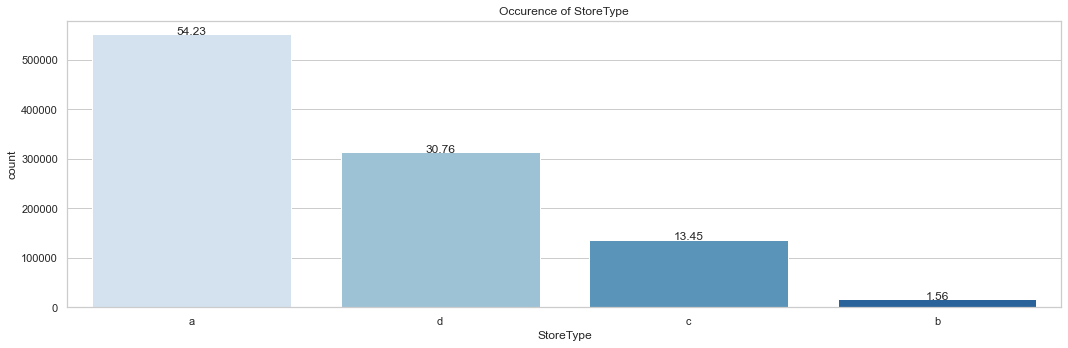

In [37]:
show_counts(df, "StoreType")

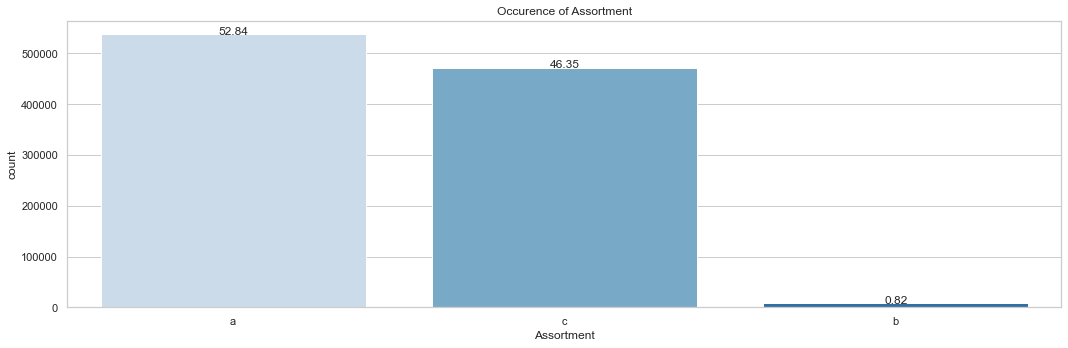

In [38]:
show_counts(df, "Assortment",)

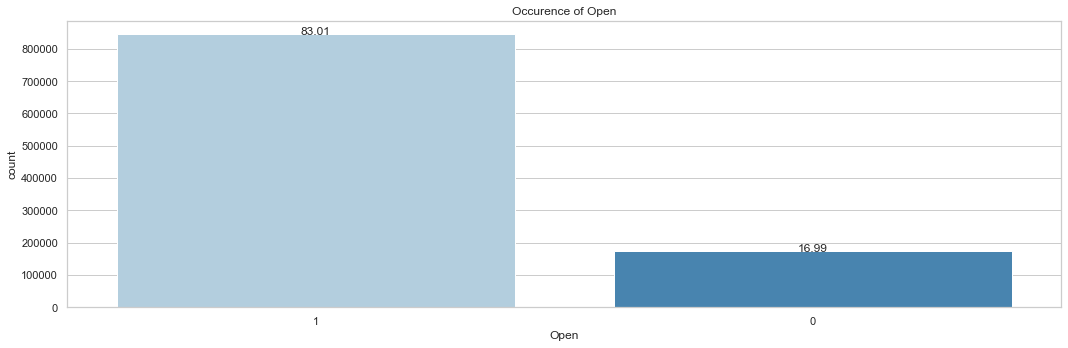

In [39]:
show_counts(df, "Open")

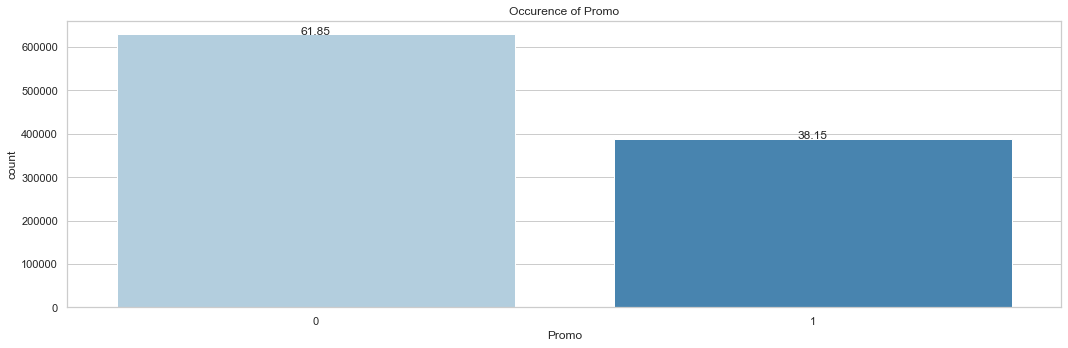

In [40]:
show_counts(df, "Promo")

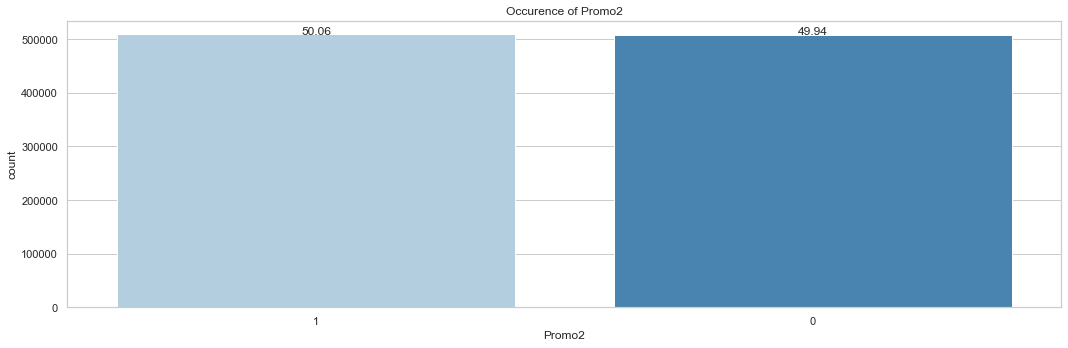

In [41]:
show_counts(df, "Promo2")

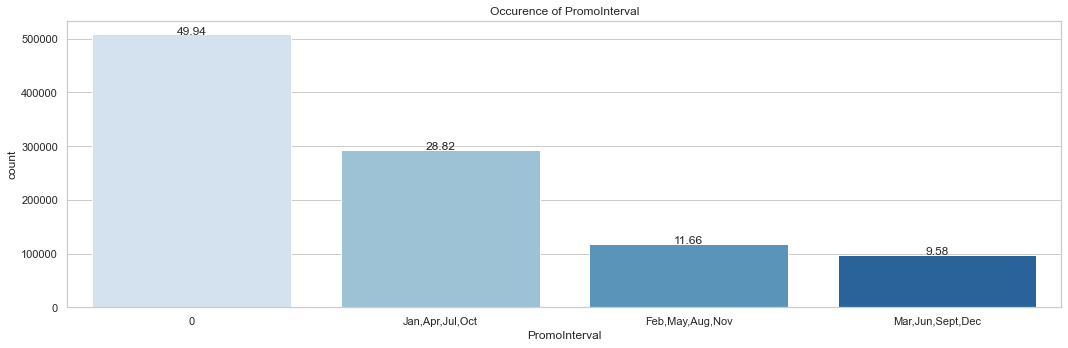

In [42]:
show_counts(df, "PromoInterval")

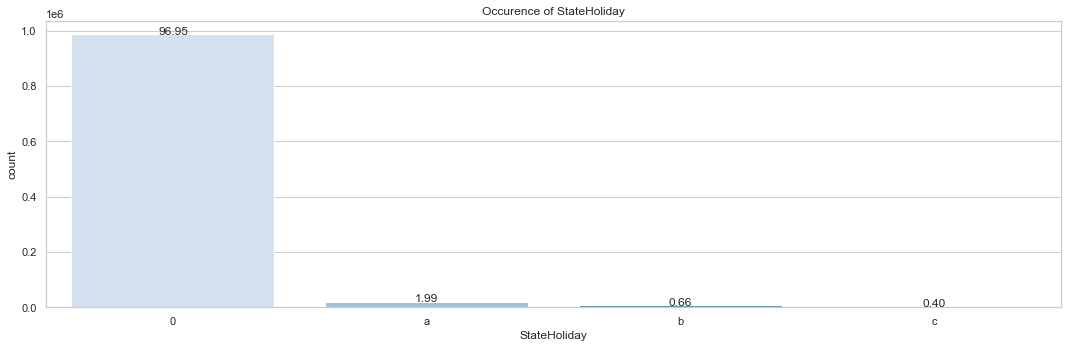

In [43]:
show_counts(df, "StateHoliday")

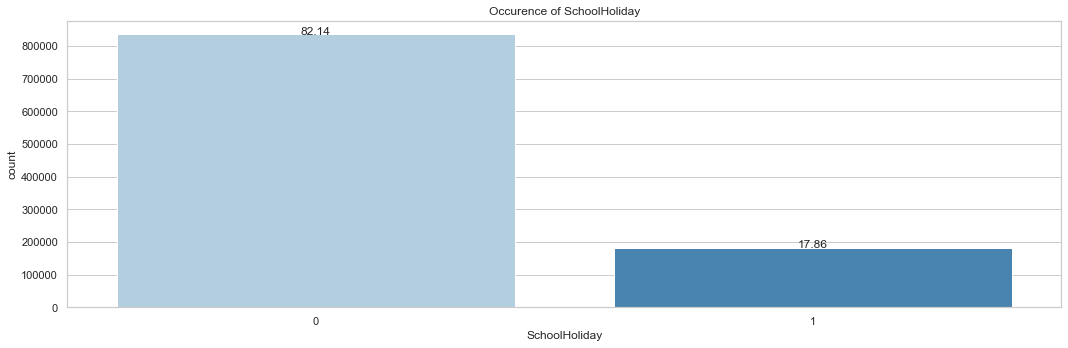

In [44]:
show_counts(df, "SchoolHoliday")

### *Les dates et valeurs temporelles*

Le jeu de données contient plusieurs variables temporelles (Date, CompetitionOpenSince..., Promo2Since...), sous **plusieurs formats**.

Pour préparer les prochaines analyses multivariées, il pourrait être intéressant de *reformuler* ces variables dans des formats exploitables par les analyses.

> <font color='blue'>**Implémentez les différentes transformations décrites dans les cellules qui suivent, qui portent sur les variables temporelles.**
</font>

>> <font color='blue'>Extraire le **jour**, le **mois** et **l'année** de la colonne 'Date' :
</font>

In [45]:
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

>> <font color='blue'>Créez une colonne **'CompetitionOpenSince'**, contenant la date d'ouverture de la competition, à partir des colonnes 'CompetitionOpenSinceMonth/Year'.<br><br> Par exemple, transformer **'CompetitionOpenSinceMonth'=9** et **'CompetitionOpenSinceYear'=2012** en **'CompetitionOpenSince'="2012-09-01"**.
</font>

In [46]:
store["CompetitionOpenSinceYear"] = store["CompetitionOpenSinceYear"].astype("int")
store["CompetitionOpenSinceMonth"] = store["CompetitionOpenSinceMonth"].astype("int")

def create_date_first_competitor(row):
    """
    Returns date of opening of the competition, from a single raw of df.
    The row must contain 'CompetitionOpenSinceMonth/Year' columns.
    
    return : 
        the date of the arrival of the first competitor
    """
    try:
        month = int(row['CompetitionOpenSinceMonth'])
        year = int(row['CompetitionOpenSinceYear'])
        date = pd.to_datetime(datetime.date(year, month, 1))        
        return date
    except:
        return 0
    
store['CompetitionOpenSince'] = store.apply(lambda row: create_date_first_competitor(row), axis=1)

In [47]:
## Sanity Check
len(store[store["CompetitionOpenSince"]==0])

354

In [48]:
## Ajouter cette colonne au data frame df
df = df.merge(store[["Store","CompetitionOpenSince"]], how="left", on="Store")

>> <font color='blue'>Créer une colonne **'Promo2Since'**, contenant la date à laquelle le magasin a commencé à participer à promo2 à partir des colonnes 'Promo2Since...'
</font>

In [49]:
store["Promo2SinceYear"] = store["Promo2SinceYear"].astype("int")
store["Promo2SinceWeek"] = store["Promo2SinceWeek"].astype("int")

def create_date_first_promo2(row):
    """
    Returns date of opening of the competition, from a single raw of df.
    The row must contain 'CompetitionOpenSinceMonth/Year' columns.
    
    return : 
        the date of the first time a store participated in promo2
    """
    
    if row["Promo2SinceYear"] != 0 :
        year = str(int(row["Promo2SinceYear"]))
        week = str(int(row["Promo2SinceWeek"]))
        d = year+'-W'+week
        return datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
    else:
        return 0
    
store['Promo2Since'] = store.apply(lambda row: create_date_first_promo2(row), axis=1)

In [50]:
## Sanity Check
len(store[store["Promo2Since"]==0])

544

In [51]:
## Ajouter cette colonne au data frame df
df = df.merge(store[["Store","Promo2Since"]], how="left", on="Store")

### *Premiers enseignements tirés*

- ...
- ...
- ...

## 2.2 Analyses multivariées

### *Evolution temporelle des ventes*

<h5> Moyennes des ventes par jour </5>

> <font color='blue'>**Affichez l'évolution des ventes moyennes par jour. Sur le même graphe, affichez également l'écart type des séries de ventes quotidiennes. Dans le script ou fonction implémentés, vous pouvez rajouter des instructions vous permettant de filtrer sur les dates pour faciliter la réutilisation.**
</font>

In [52]:
### Commençons par calculer les moyennes et std des séries de ventes quotidiennes..
sales_by_date = df.groupby('Date').agg({'Sales':['mean', 'std']})
sales_by_date.head()

Sales         
               mean      std
Date                        
2013-01-01    87.28   844.05
2013-01-02 6,233.03 2,633.56
2013-01-03 5,693.11 2,362.00
2013-01-04 5,954.22 2,313.19
2013-01-05 5,337.75 2,655.26

In [53]:
## Le data frame précédent est indexé par une colonne datetime. 
## Avec ce type datetime, on peut filtrer le data frame de façon très simple :
## 1- sur une année uniquement
sales_by_date["2014"].head(5)

Sales         
               mean      std
Date                        
2014-01-01   105.93   985.76
2014-01-02 6,260.59 2,405.14
2014-01-03 6,299.78 2,287.39
2014-01-04 5,701.58 2,623.12
2014-01-05   165.83 1,391.71

In [54]:
## 2- sur un mois uniquement
sales_by_date["2014-05"].head(5)

Sales         
                mean      std
Date                         
2014-05-01    213.52 1,857.81
2014-05-02 10,144.12 3,501.26
2014-05-03  6,143.80 2,798.73
2014-05-04    204.04 1,568.03
2014-05-05  9,683.46 3,276.50

In [55]:
## 3- entre une date de début et une date de fin
sales_by_date["2014-05-05":"2014-05-10"].head(5)

Sales         
               mean      std
Date                        
2014-05-05 9,683.46 3,276.50
2014-05-06 8,138.00 2,794.51
2014-05-07 7,580.11 2,656.02
2014-05-08 7,494.62 2,552.99
2014-05-09 7,823.00 2,630.44

>> <font color='blue'>**A partir de ces infos, nous allons implémenter une fonction qui permet d'afficher la distribution temporelle des ventes (ou d'une autre variable), avec la possibilité de filtrer sur les dates.**
</font>

In [56]:
def temporal_evolution(
    df, 
    date_col="Date", 
    target_col="Sales", 
    agg=["mean","std"], 
    filter_date1=None, 
    filter_date2=None,
    figsize = (15,5),
):
    """
    """
    var_by_date = df.groupby(date_col).agg({target_col:agg})
    
    if filter_date1 is not None and filter_date2 is None:
        var_by_date = var_by_date[filter_date1]
    elif all(date is not None for date in [filter_date1, filter_date2]):
        var_by_date = var_by_date[filter_date1:filter_date2]
        
    var_by_date.plot(figsize=figsize)
    plt.title('Evolution temporelle - ' + target_col + ' - ' + str(agg))
    plt.ylabel(target_col + ' - ' + str(agg))
    plt.show()

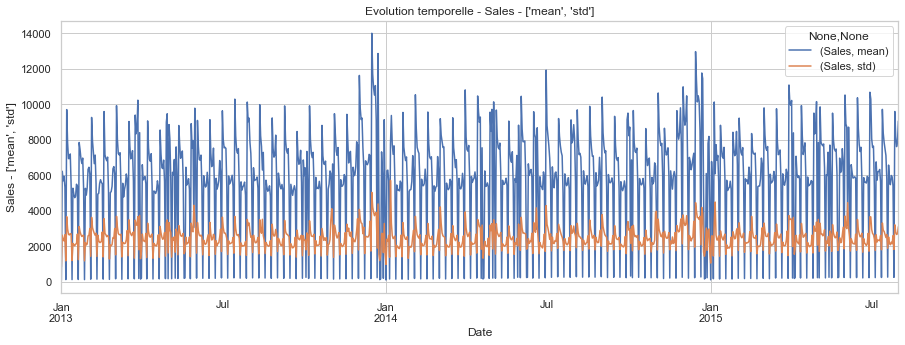

In [57]:
temporal_evolution(
    df, 
    date_col="Date", 
    target_col="Sales", 
    agg=["mean","std"],
)

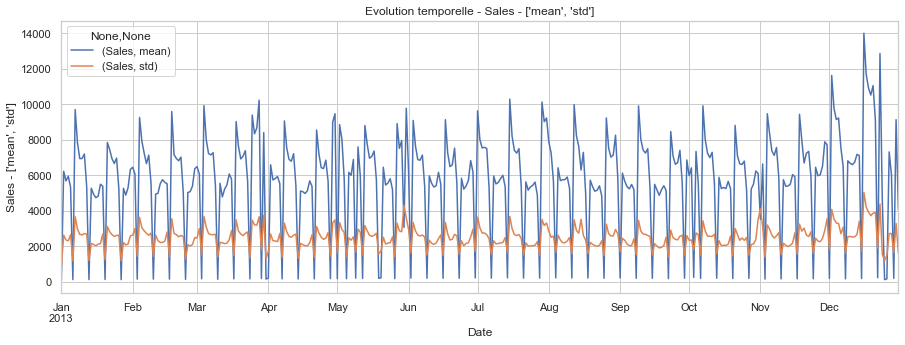

In [58]:
## Sur une année entière uniquement
temporal_evolution(
    df, 
    date_col="Date", 
    target_col="Sales", 
    agg=["mean","std"], 
    filter_date1="2013", 
)

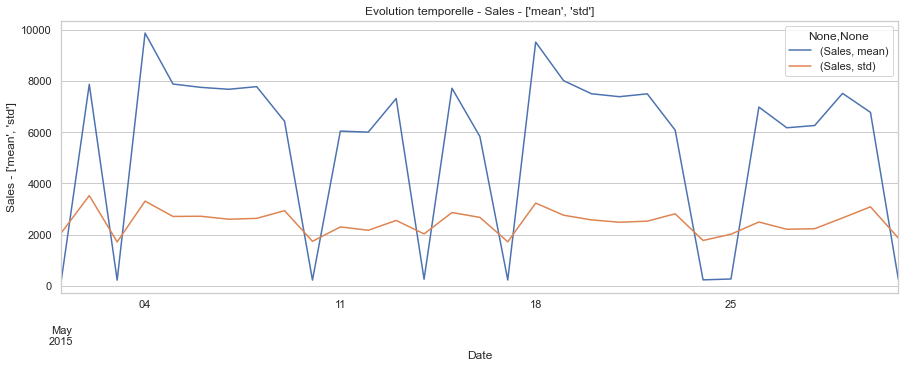

In [59]:
## Sur un mois uniquement
temporal_evolution(
    df, 
    date_col="Date", 
    target_col="Sales", 
    agg=["mean","std"], 
    filter_date1="2015/05", 
)

- Cette analyse à grosse maille nous donne une idée globale sur la tendance et la saisonnalité...
- ...Il faut cependant tenir compte dans l'interprétation de ces résultats qu'il s'agit d'une moyenne des ventes sur tous les magasins.

- Au moment des fêtes de fin d'année, les ventes moyennes connaissent un pic (saisonnalité annuelle)
- On n'observe pas de tendance particulière
- A noter la variance élevée (line orange) des ventes. Les magasins ont des résultats de ventes qui diffèrent (significativement) les uns des autres 


> <font color='blue'>**Affichez les évolutions des ventes en fonction du jour de la semaine puis du mois.**
</font>

<h5>Ventes moyennes par jour de semaine</h5>

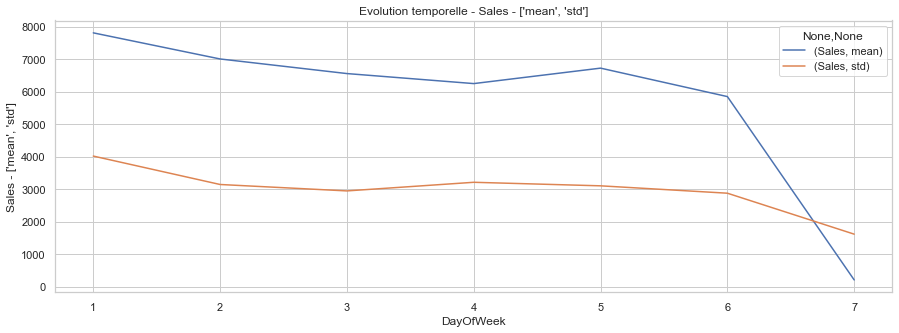

In [60]:
## Pour utiliser la fonction temporal_evolution() avec les semaines, les paramètres filter_date doivent être None
temporal_evolution(
    df, 
    date_col="DayOfWeek", 
    target_col="Sales", 
    agg=["mean","std"], 
    filter_date1=None, 
)

In [61]:
sales_by_week = df.groupby("DayOfWeek")["Sales"].mean().reset_index()
sales_by_week

,DayOfWeek,Sales
0,1,"7,809.04"
1,2,"7,005.24"
2,3,"6,555.88"
3,4,"6,247.58"
4,5,"6,723.27"
5,6,"5,847.56"
6,7,204.18


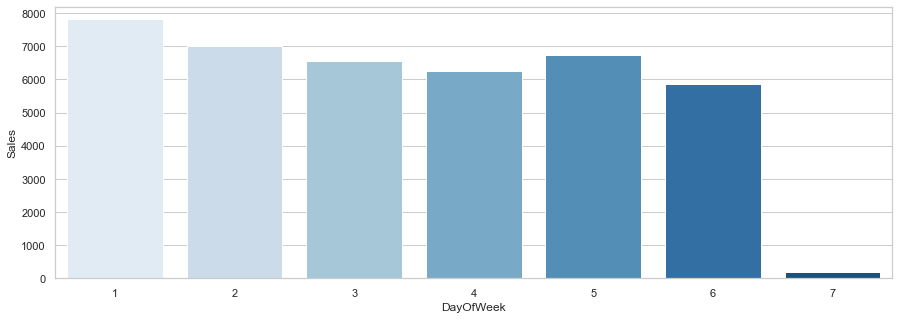

In [62]:
fig, ax = plt.subplots(1, figsize=(15,5))

sns.barplot(data = sales_by_week, x = "DayOfWeek", y = "Sales", palette="Blues", ax=ax);
fig.show()

>> <font color='blue'>**Affichez la distribution des ventes par jour de semaine. On peut par exemple afficher 7 boxplots, 1 pour chaque jour.**
</font>

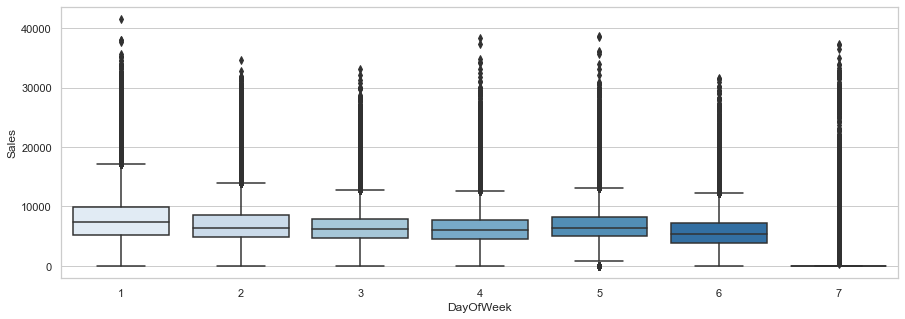

In [63]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="DayOfWeek", 
    y="Sales", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)
fig.show()

- On observe un pattern qui se répète chaque semaine :
    - Un nombre significativement plus élevé de ventes en début de semaines, baisse progressive des ventes puis une légère augmentation en fin de semaine (vendredi), et une chute considérable des ventes le dimanche.
- Les stores sont quasiment tous  fermés le dimanche 

<h5> Ventes moyennes par mois </5>

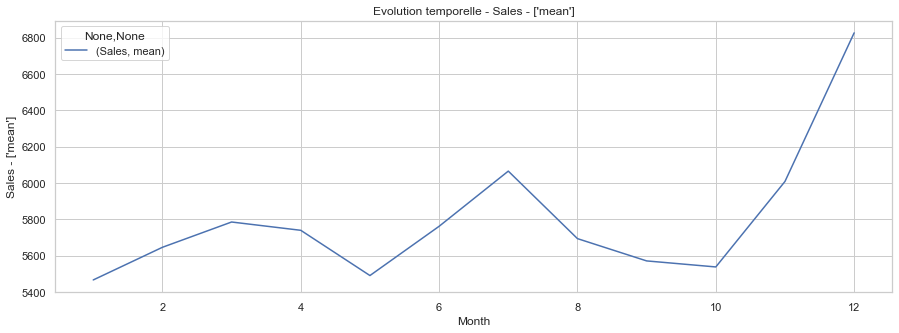

In [64]:
## Pour utiliser la fonction temporal_evolution(), les paramètres filter_date doivent être None
temporal_evolution(
    df, 
    date_col="Month", 
    target_col="Sales", 
    agg=["mean"], 
    filter_date1=None, 
)

### *Jours fériés et Vacances scolaires*

<h5>Jours fériés (State Holiday)</h5>

> <font color='blue'>**Est-ce qu'il y a des ventes lors des jours fériés ? Comment sont distribuées les ventes dans les jours fériés s'il y en a ?**
</font>

In [65]:
## Combien de magasins ont ouvert lors d'un state holiday ?
open_state_holiday = df[(df["StateHoliday"]!="0") & (df["Open"]==1)]
store_open_state_holiday = open_state_holiday["Store"].unique()
n_obs_open_state_holiday = len(open_state_holiday)
print("Le nombre de stores ayant ouvert pendant un jour férié : {}".format(len(store_open_state_holiday)))
print("Le nombre d'obs avec store ouvert un jour férié : {}".format(n_obs_open_state_holiday))

Le nombre de stores ayant ouvert pendant un jour férié : 156
Le nombre d'obs avec store ouvert un jour férié : 910


> <font color='blue'>**Affichez la distribution des ventes dans les jours fériés et les jours non fériés.**
</font>

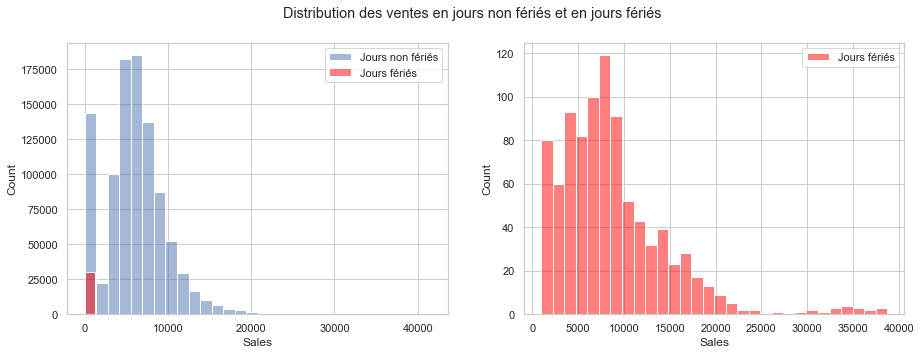

In [66]:
## DIstributions des ventes jours fériés / jours non fériés

fig, ax = plt.subplots(1, 2, figsize=(15,5))

## Jours non fériés, superposé jours fériés
sns.histplot(
    data = df[df["StateHoliday"]=="0"],
    x="Sales", 
    bins=30,
    stat = "count",
    alpha = 0.5,
    label = "Jours non fériés",
    ax = ax[0]
)
sns.histplot(
    data = df[df["StateHoliday"]!="0"],
    x="Sales", 
    bins=30,
    stat = "count",
    color = "red",
    alpha = 0.5,
    label = "Jours fériés",
    ax = ax[0]
)

## Focus jours non fériés uniquement
sns.histplot(
    data = df[(df["StateHoliday"]!="0") & (df["Open"]==1)],
    x="Sales", 
    bins=30,
    stat = "count",
    color = "red",
    alpha = 0.5,
    label = "Jours fériés",
    ax = ax[1]
)

ax[0].legend()
ax[1].legend()
fig.suptitle("Distribution des ventes en jours non fériés et en jours fériés")
fig.show()

- Sans surprise, il y a peu de magasins qui ouvrent lors d'un jour férié, et les ventes lors des jours fériés sont très faibles. 
- Qu'en est-il des **ventes avant (à l'approche)** des jours fériés (qui peuvent être accompagnés de vacances scolaires) ? Les consommateurs ont-ils tendance a acheté plus avant ces jours fériés, étant donné la fermeture de la majorité des magasins pendant ces jours fériés, l'approche de voyages possibles (dans le cas des vacances scolaires)... 
> <font color='blue'>**Quel(s) analyse(s) / graphique(s) peut-on réaliser pour vérifier ce scénario ? Quelle variable peut-on créer ?**
</font>

In [67]:
## Quelles sont les dates de State Holiday ?
state_holidays = (df[df["StateHoliday"]!="0"]["Date"].unique())
print(len(state_holidays))

37


In [68]:
## Est-ce que c'est les mêmes State Holiday pour tous les magasins ?
df_st_holidays = df[df["Date"].isin(state_holidays)]
df_st_holidays = df_st_holidays.groupby("Date")["StateHoliday"].unique()
df_st_holidays

Date
2013-01-01       [a]
2013-01-06    [0, a]
2013-03-29       [b]
2013-04-01       [b]
2013-05-01       [a]
2013-05-09       [a]
2013-05-20       [a]
2013-05-30    [a, 0]
2013-08-15    [0, a]
2013-10-03       [a]
2013-10-31    [0, a]
2013-11-01    [0, a]
2013-11-20    [0, a]
2013-12-25       [c]
2013-12-26       [c]
2014-01-01       [a]
2014-01-06    [0, a]
2014-04-18       [b]
2014-04-21       [b]
2014-05-01       [a]
2014-05-29       [a]
2014-06-09       [a]
2014-06-19    [a, 0]
2014-10-03       [a]
2014-10-31    [0, a]
2014-11-01    [0, a]
2014-11-19    [0, a]
2014-12-25       [c]
2014-12-26       [c]
2015-01-01    [a, 0]
2015-01-06    [0, a]
2015-04-03       [b]
2015-04-06       [b]
2015-05-01       [a]
2015-05-14       [a]
2015-05-25       [a]
2015-06-04    [a, 0]
Name: StateHoliday, dtype: object

>> <font color='blue'>**Affichez sur un graphe, pour un magasin donné, l'évolution quotidienne des ventes. Sur ce même graphes, affichez des lignes verticales indiquant un jour férié.**<br><br>
L'objectif est d'identifier des tendances particulières qui précèdent ou suivent ces jours fériés. Si ces intuitions se confirment (hausse avant les jours fériés par exemple), une variable *"Nombre de jours jusqu'au prochain jour férié"* pourrait être intéressante à explorer.**
</font>

In [69]:
### Evolution ventes avant / après state holiday

## Extraire pour chaque Store la liste de toutes les State Holidays qui le concernent
dates_state_holidays = df[df["StateHoliday"]!="0"]
dates_state_holidays = dates_state_holidays.groupby("Store")["Date"].apply(lambda x: sorted(list(x))).reset_index()
dates_state_holidays = dates_state_holidays.rename(columns = {"Date": "DatesOfStateHolidays"})

## Ajouter cette information au data frame principal df
df = df.merge(dates_state_holidays, how="left", on="Store")

In [70]:
### Plot sales evolution for a store and highlight beginning of state holidays
def sales_and_state_holiday(df, store_id, filter_year=None, figsize=(15,5)):
    """
    Pour un store_id dans le data frame df, afficher l'évolution quotidienne des ventes (Sales).
    Le graphe affichera également des barres verticales indiquant les jours fériés qui concernent ce magasin.
    """       
    fig, ax = plt.subplots(1, figsize=figsize)

    subset_store = df[df["Store"] == store_id].set_index('Date')
    dates_state_holidays = subset_store["DatesOfStateHolidays"].values[0]
    if filter_year is not None:
        subset_store = subset_store[str(filter_year)]
        dates_state_holidays = [d for d in dates_state_holidays if d.year==filter_year]

    subset_store.Sales.plot()
    for date in dates_state_holidays:
        ax.axvline(
            datetime.date(date.year, date.month, date.day), 
            color='red', 
            label='State Holiday')

    fig.show()

In [ ]:
## Modifier les paramètres et relancer
sales_and_state_holiday(df, 500, 2015)

- La visualisation pour chaque store ne permet pas de tirer de conclusions claires.
- On pourrait s'intéresser au même graphe, avec les ventes moyennes pour tous les magasins concernés par un jour férié...?

>> [Optional] <font color='blue'>**Créer une variable qui indique, pour chaque couple (magasin, date), le nombre de jours restants avant le prochain State Holiday ?**
</font>

In [74]:
...

Ellipsis

<h5>Vacances Scolaires</h5>

> <font color='blue'>**Quel est l'impact des vacances scolaires sur les ventes moyennes ?**
</font>

In [75]:
sales_school_holiday = df.groupby(['SchoolHoliday']).agg({'Sales':'mean'})
sales_school_holiday

,Sales
SchoolHoliday,
0,"5,620.98"
1,"6,476.52"


>> <font color='blue'>**Affichez la distribution des ventes en vacances scolaires et en dehors de vacances scolaires. On peut par exemple afficher deux boxplot l'un à côté de l'autre.**
</font>

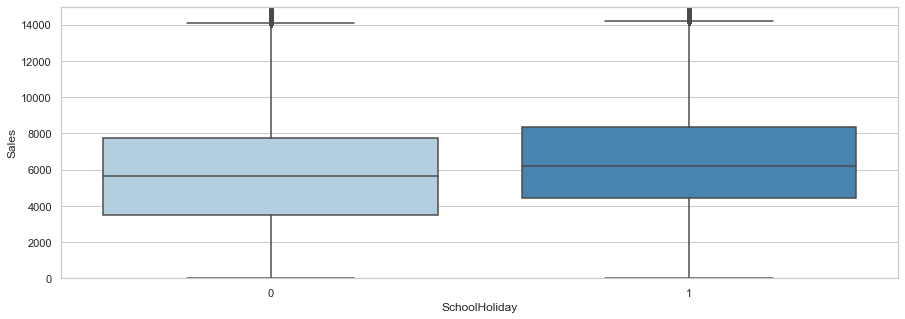

In [76]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="SchoolHoliday", 
    y="Sales", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = 15000
ax.set_ylim([0, sales_max])  

fig.show()

- Les ventes moyennes journalières sont plus élevées durant les vacances scolaires qu'en période hors vacances scolaires.
- Comme **pistes à explorer**, on pourrait s'intéresser à la saison des vacances scolaires (printemps-été, automne-hiver)...

### *Ventes et différents types de magasins et d'assortiment*

<h5>Ventes par type StoreType</h5>

> <font color='blue'>**Est-ce qu'il y a une différence dans les moyennes des ventes en fonction du type du magasin ? C'est différences sont-elles significatives (en se basant sur la répartition des StoreType dans le jeu d'observations) ?**
</font>

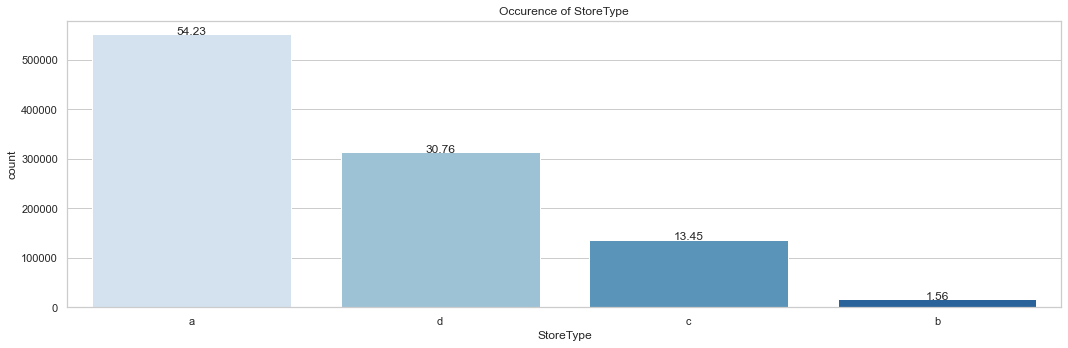

In [77]:
## Rappel
show_counts(df, "StoreType")

>> <font color='blue'>**Afficher l'évolution quotidienne et les distribution de ventes en fonction de type de magasin.**
</font>

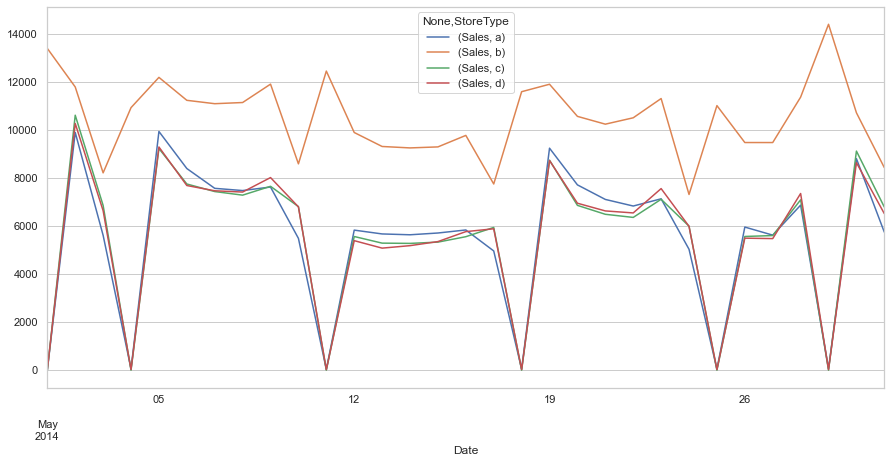

In [78]:
# By StoreTye
store_type_sales = df.groupby(['Date','StoreType']).agg({'Sales':'mean'}) 
store_type_sales = store_type_sales.unstack()

filter_date = "2014/05"
if filter_date is not None:
    store_type_sales = store_type_sales[filter_date]

store_type_sales.plot(figsize=(15,7))
plt.show()

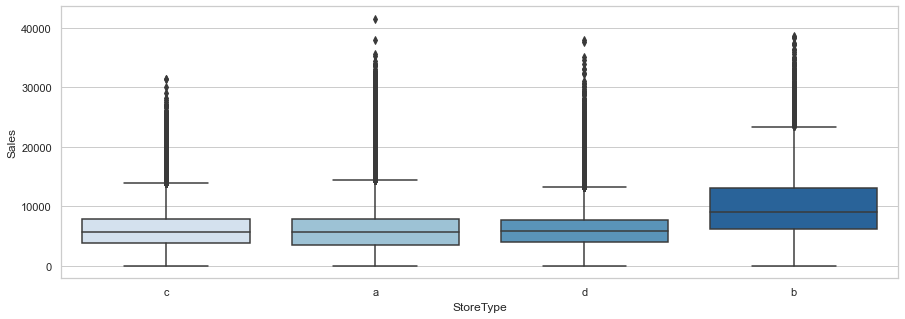

In [79]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="StoreType", 
    y="Sales", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

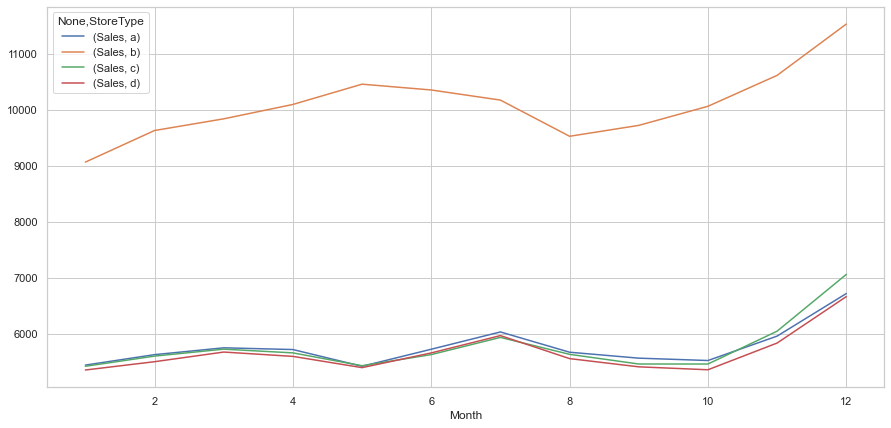

In [80]:
# By StoreType and month of year
store_type_month = df.groupby(['Month','StoreType']).agg({'Sales':'mean'}) 
store_type_month = store_type_month.unstack()

store_type_month.plot(figsize=(15,7))
plt.show()

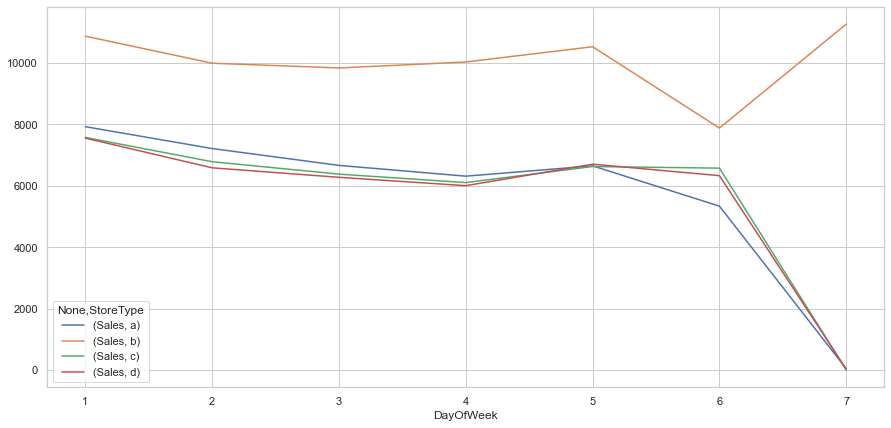

In [81]:
# By StoreTye and day of week
store_type_dayweek = df.groupby(['DayOfWeek','StoreType']).agg({'Sales':'mean'}) 
store_type_dayweek = store_type_dayweek.unstack()

store_type_dayweek.plot(figsize=(15,7))
plt.show()

- De faibles différences dans les moyennes de ventes entre les magasins de type a, c, d
- Les stores de **type b** vendent plus en moyenne que les autres stores. Cependant, ils ne représentent qu'une faible proportion des stores (~1.5%)
- Les Stores de types b sont visiblement les seuls qui ouvrent le dimanche.

<h5>Ventes par type Assortment</h5>

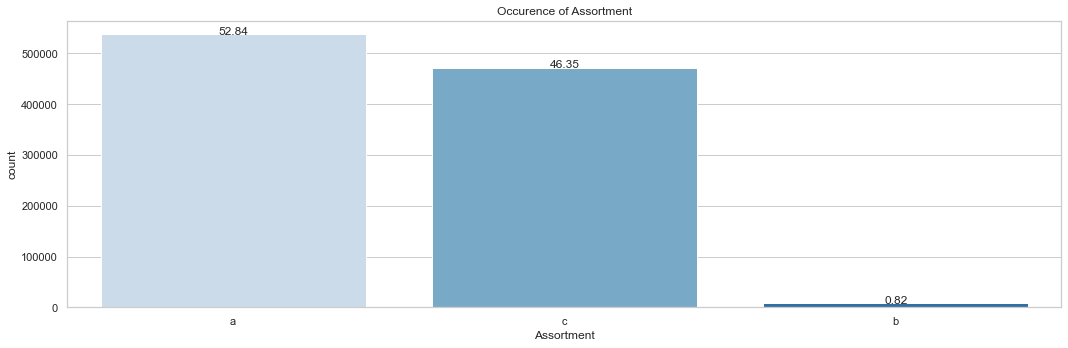

In [82]:
show_counts(df, "Assortment")

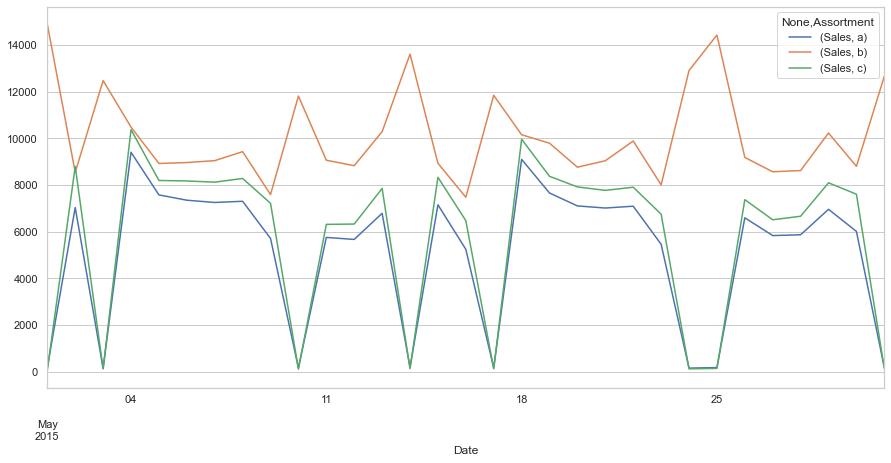

In [83]:
# By StoreTye
store_type_sales = df.groupby(['Date','Assortment']).agg({'Sales':'mean'}) 
store_type_sales = store_type_sales.unstack()

filter_date = "2015/05"
if filter_date is not None:
    store_type_sales = store_type_sales[filter_date]

store_type_sales.plot(figsize=(15,7))
plt.show()

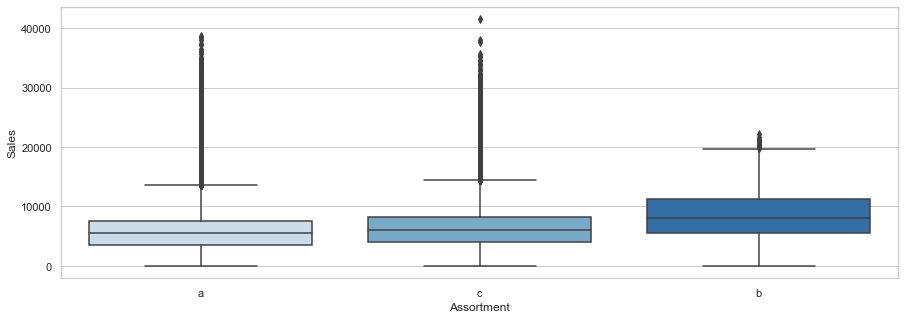

In [84]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="Assortment", 
    y="Sales", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

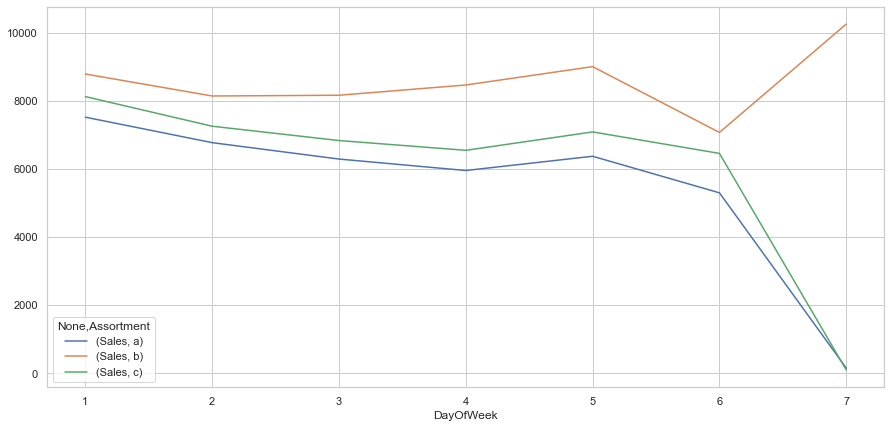

In [85]:
# By StoreTye and day of week
store_type_dayweek = df.groupby(['DayOfWeek','Assortment']).agg({'Sales':'mean'}) 
store_type_dayweek = store_type_dayweek.unstack()

store_type_dayweek.plot(figsize=(15,7))
plt.show()

- Moyennes des ventes différentes selon l'assortiment
- Les assortiments **'b' (extra)** vendent plus (en CA). On peut également remarquer une légère tendance à la hausse. Cependant il y en a encore très peu (- de 1%). Ils constituent d'ailleurs une part très faible du CA.  Il serait donc intéressant d'étudier la possibilité d'augmenter le nombre de ce type de magasin ?
- Les gammes de magasins a = 'basic' et c = 'extended' sont similaires au niveau de leur nombre de ventes. 

<h5> Types de produit par assortment </h5>

- L'analyse des **ventes moyennes par customer** peut être utile pour indiquer le type de produit dans chaque type d'assortiment magasin...

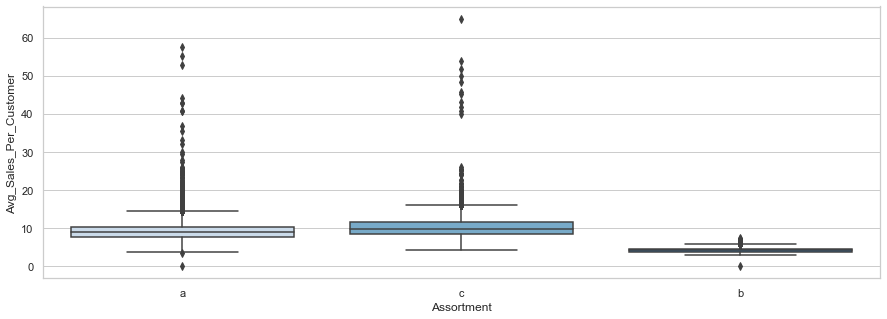

In [86]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="Assortment", 
    y="Avg_Sales_Per_Customer", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

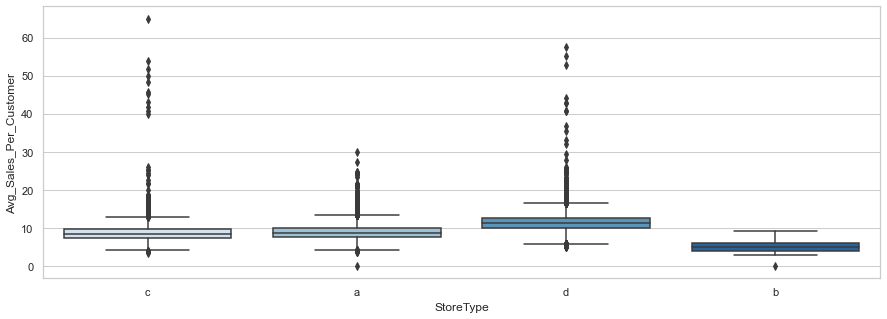

In [87]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="StoreType", 
    y="Avg_Sales_Per_Customer", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

ValueError: Could not interpret input 'Customer'

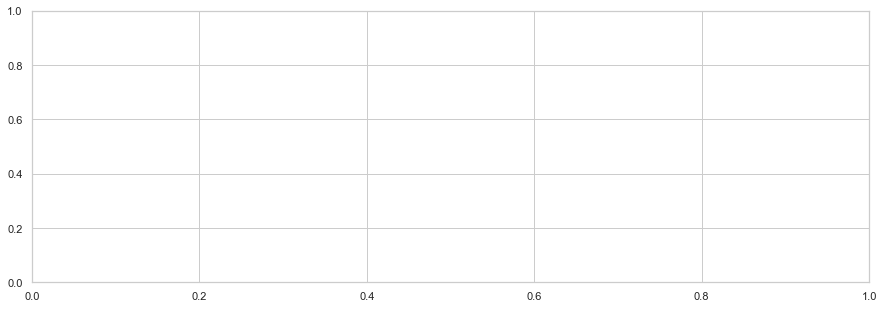

In [88]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="Assortment", 
    y="Customer", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

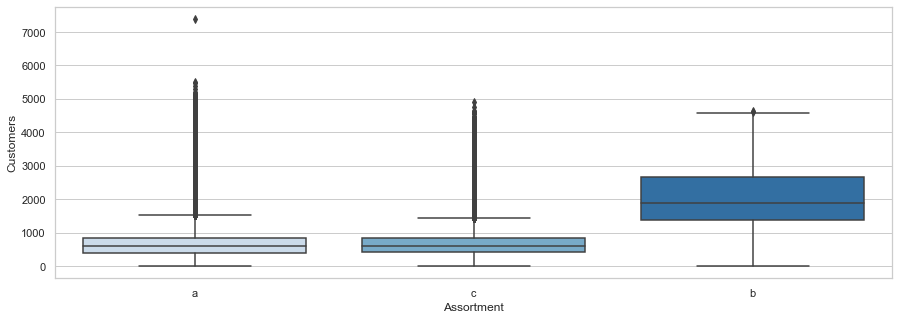

In [90]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="Assortment", 
    y="Customers", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

In [91]:
# store.groupby(["StoreType", "Assortment"])["Store"].count().unstack().plot(kind="bar")

- Le panier moyen dans les magasins avec assortiment 'b' est ~2 fois plus petit que dans les autres magasins (environ 4 euros contre 9-10 pour les assortments 'a' et 'b'), leur plus forte rentabilité (cf graphes Sales) peut être expliquée par le nombre moyens de clients par store beaucoup plus important (2000 contre 600 pour les autres types de stores)

### *Ventes et promotion*

> <font color='blue'>**Combien de magasins proposent des promotions à une date donnée ? Est-ce qu'il y a un pattern des promotions définis (promo tous les 1 du mois, toutes les semaines, ...) ? Comment sont impactées les ventes par les promo ? ...**<br><br>
*Les analyses sur les promo permettent d'évaluer la pertinence de ces variables pour la prédiction des ventes (donc l'impact des promo sur les ventes), et peut aussi mener vers d'autres cas d'usage et analyses approfondie qui porteraient par exemple sur la recherche de la meilleure stratégie de promo pour maximiser les ventes, ...*
</font>

In [92]:
## % de store en promo, à une date donnée
promo_in_stores = df.groupby('Store').agg({'Promo':'mean', "Promo2":'mean'})
promo_in_stores

,Promo,Promo2
Store,,
1,0.38,0
2,0.38,1
3,0.38,1
4,0.38,0
5,0.38,0
...,...,...
1111,0.38,1
1112,0.38,0
1113,0.38,0


In [93]:
promo_in_stores.describe()

,Promo,Promo2
count,"1,115.00","1,115.00"
mean,0.38,0.51
std,0.00,0.50
min,0.38,0.00
25%,0.38,0.00
50%,0.38,1.00
75%,0.38,1.00
max,0.38,1.00


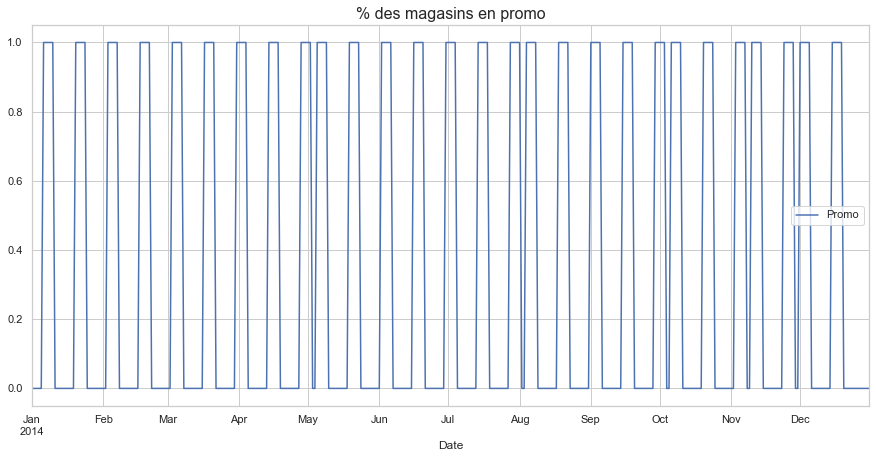

In [94]:
#plot le pourcentage de store en promo chaque jour 
promo_by_date = df.groupby('Date').agg({'Promo':'mean'})

filter_date1 = "2014"
filter_date2 = None
if filter_date1 is not None and filter_date2 is None:
    promo_by_date = promo_by_date[filter_date1]    
elif all(f_date is not None for f_date in [filter_date1, filter_date2]):
    promo_by_date = promo_by_date[filter_date1:filter_date2]
    
promo_by_date.plot(figsize = (15,7))
plt.title('% des magasins en promo', fontsize=16)
plt.show()

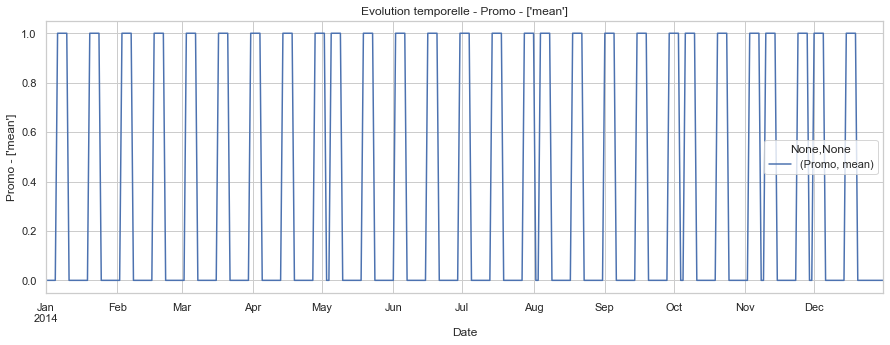

In [95]:
## On peut réutiliser la fonction temporal_evoltion
temporal_evolution(df, date_col="Date", target_col="Promo", agg=["mean"], filter_date1="2014")

- Tous les stores sont en promo en même temps et il y a une promotion plus d'un jour sur 3
- Le pattern des promotions est assez précis : une promotion toutes les 2 semaines
- Il n'y a pas de promotions le week end !
- A la fin du mois de Mars, d'Avril et fin-mai/début juin, on a deux semaines de promo consécutives
- Il n'y a pas de promotions au moment des fêtes de fin d'années...

> <font color='blue'>**Quelles différences entres les ventes moyennes par jour de la semaine selon la présence ou non de promotion ?**
</font>

In [96]:
daily_sales_by_promo = df.groupby(['Promo', 'DayOfWeek']).agg({'Sales':'mean'})
daily_sales_by_promo

Sales
Promo DayOfWeek         
0     1         5,604.36
      2         5,612.05
      3         5,418.55
      4         5,097.57
      5         6,178.61
      6         5,847.56
      7           204.18
1     1         9,707.81
      2         8,227.91
      3         7,554.02
      4         7,259.50
      5         7,202.54

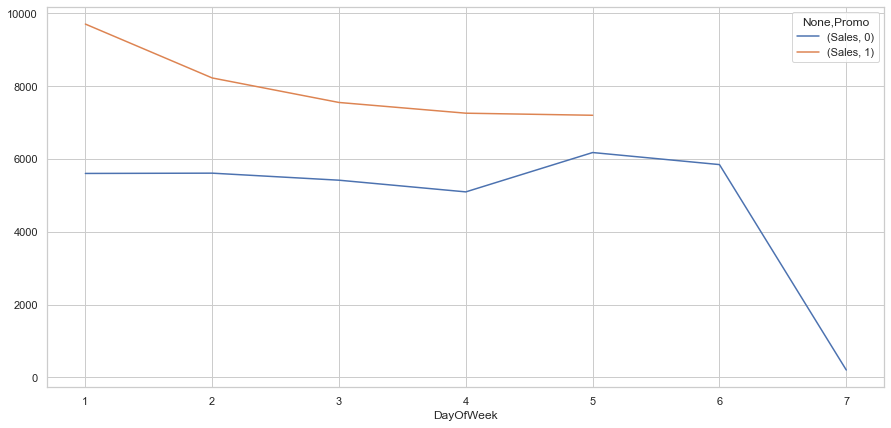

In [97]:
## En lineplot
promo_sales_dayweek = df.groupby(['DayOfWeek','Promo']).agg({'Sales':'mean'}) 
promo_sales_dayweek = promo_sales_dayweek.unstack()

promo_sales_dayweek.plot(figsize=(15,7))
plt.show()

>> <font color='blue'>**Affichez pour chaque jour de la semaine, les distributions des ventes dans le cas avec promo et sans promo. Que peut-on dire de cette variable Promo et son utilité pour les modèles ?**
</font>

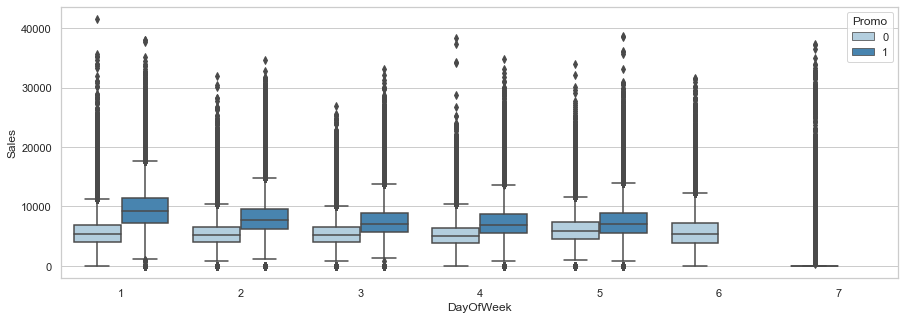

In [98]:
fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="DayOfWeek", 
    y="Sales", 
    hue="Promo", 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

- Il n'y a pas de promotion durant le weekend (samedi et dimanche)
- Les ventes moyennes en périodes de promotions sont **multipliées par 1.7 en début de semaine** (lundi et mardi) et par environ **1.5 les autres jours de la semaine** !
- L'impact de cette variable (de la promo) apparait important.

> <font color='blue'>**Affichez les distributions des ventes en promo / sans promo, sans autre filtre. Par exemple, affichez les distributions en deux histogrammes superposés**
</font>

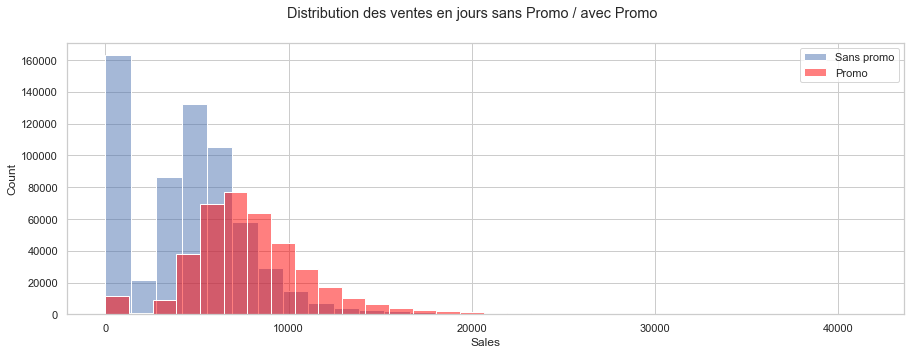

In [99]:
fig, ax = plt.subplots(1, figsize=(15,5))

## Ventes Jours sans promo, superposé jours avec promo
sns.histplot(
    data = df[df["Promo"]==0],
    x="Sales", 
    bins=30,
    stat = "count",
    alpha = 0.5,
    label = "Sans promo",
    ax = ax
)
sns.histplot(
    data = df[df["Promo"]!=0],
    x="Sales", 
    bins=30,
    stat = "count",
    color = "red",
    alpha = 0.5,
    label = "Promo",
    ax = ax
)

ax.legend()
fig.suptitle("Distribution des ventes en jours sans Promo / avec Promo")
fig.show()

<h5> Zoom sur Promo2 </h5>

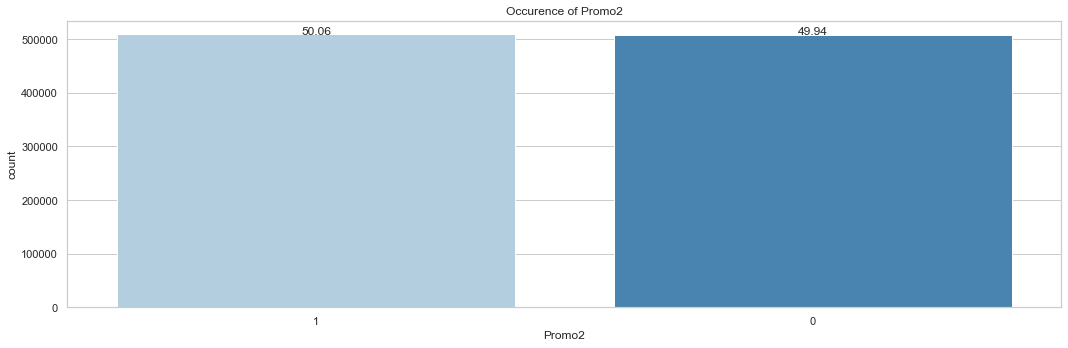

In [100]:
show_counts(df, "Promo2")

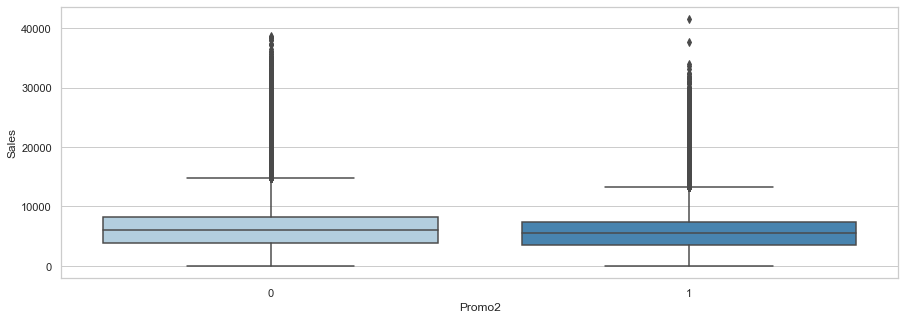

In [101]:
## Boxplot distributions des ventes en Promo2 / hors promo2

fig, ax = plt.subplots(1, figsize=(15,5))
sns.boxplot(
    x="Promo2", 
    y="Sales", 
    hue=None, 
    data=df, 
    palette="Blues", 
    ax=ax)

## Play with ylim to have a clearer visualisation of distrib
sales_max = None
if sales_max is not None:
    ax.set_ylim([0, sales_max])  

fig.show()

- Les magasins qui particpent à Promo2 sont moins rentables que ceux qui ne participent pas. C'est peut-être une raison pour laquelle ils ont opté pour Promo2 ?...

> <font color='blue'> On peut essayer de voir pour les magasins qui participent, **quelle a été l'évolution de leur vente avant et après le début du programme Promo2...** </font>

In [102]:
# subset des stores des magasins qui ont participé à promo2 
stores_promo2 = df[df.Promo2==1]

# on ne sélectionne que les stores qui ont commencé promo2 après le 1er janvier 2013
# sinon on ne peut pas évaluer l'effet de promo2
start_date = pd.to_datetime('2013-01-01')
subset = stores_promo2[stores_promo2["Promo2Since"] > start_date]
print('Nombre de stores qui ont commencé promo2 après le 1er Janvier 2013 :', len(subset["Store"].unique()))

Nombre de stores qui ont commencé promo2 après le 1er Janvier 2013 : 225


In [103]:
## Vérifier que Nombre de Store avant promo2 == nombre de store après
print(subset[subset["Date"] < subset["Promo2Since"]]["Store"].nunique())
print(subset[subset["Date"] >= subset["Promo2Since"]]["Store"].nunique())

subset["BeforePromo2"] = subset["Date"] < subset["Promo2Since"]

subset = subset.groupby(["Store", "BeforePromo2"])["Sales"].mean().reset_index()

225
225


>> <font color='blue'>**Affichez les distributions des moyennes de ventes pour chaque magasin participant à Promo2 après jan 2013, avant et après la participation à Promo2.**
</font>

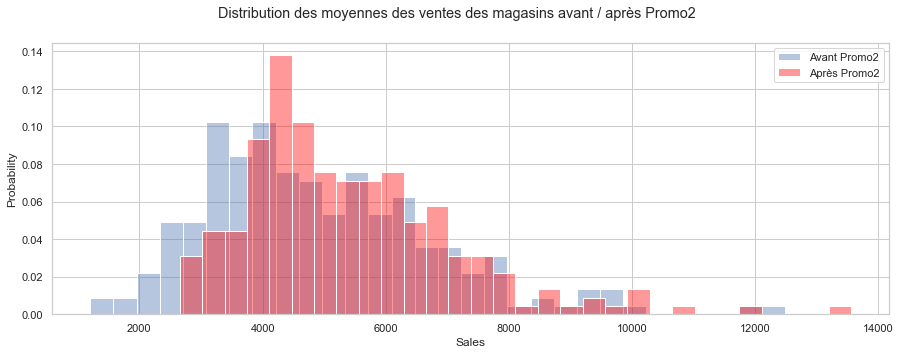

In [104]:
fig, ax = plt.subplots(1, figsize=(15,5))


## Ventes Jours sans promo, superposé jours avec promo
sns.histplot(
    data = subset[subset["BeforePromo2"]==True],
    x="Sales", 
    bins=30,
    stat = "probability",
    alpha = 0.4,
    label = "Avant Promo2",
    ax = ax
)
sns.histplot(
    data = subset[subset["BeforePromo2"]==False],
    x="Sales", 
    bins=30,
    stat = "probability",
    color = "red",
    alpha = 0.4,
    label = "Après Promo2",
    ax = ax
)

ax.legend()
fig.suptitle("Distribution des moyennes des ventes des magasins avant / après Promo2")
fig.show()

>> <font color='blue'>**Visualisez pour chaque magasin l'impact de la participation à Promo2 (impact short term ? long term? ...).**
</font>

In [105]:
def sales_and_promo2(df, store_id, figsize=(15,5)):
    """
    Returns : the temporal evolution of a store sales with the date of beginning of promo2 marked with vertical lime
    """       
    fig, ax = plt.subplots(1, figsize=figsize)

    subset_store = df[df["Store"] == store_id].set_index('Date')
    date_promo2 = subset_store["Promo2Since"].values[0]

    subset_store.Sales.plot()
    if date_promo2==0:
        print("Pas de promo2 pour ce magasin")
    elif date_promo2 < pd.to_datetime('2013-01-01'):
        print("Date de début promo2 avant janvier 2013 : ", date_promo2)
    else:
        ax.axvline(
            datetime.date(date_promo2.year, date_promo2.month, date_promo2.day), 
            color='red', 
            label='Début Promo2')

    plt.legend()
    fig.show()

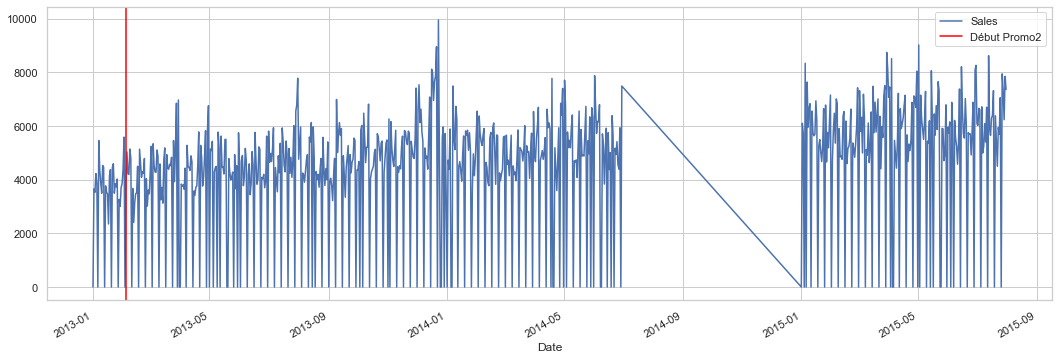

In [106]:
sales_and_promo2(df, 500, (18,6))

In [107]:
## PromoInterval ? Utilité ?
sales_by_promo_interval = df.groupby(['PromoInterval']).agg({'Sales':'mean'})
sales_by_promo_interval

,Sales
PromoInterval,
0,"6,124.71"
"Feb,May,Aug,Nov","5,311.05"
"Jan,Apr,Jul,Oct","5,562.36"
"Mar,Jun,Sept,Dec","5,143.83"


### *Ventes et présence de la compétition*

> <font color='blue'>**Quels impacts de la concurrence sur les ventes des magasins ? Les ventes sont-ils plus élevés / moins élevés si la compétition est éloignée / proche ? Que peut-on dire sur cette variable et son utilité pour les modèles ?**
</font>

In [108]:
...

Ellipsis

In [109]:
...

Ellipsis

- On remarque quelque chose d'intéressant : Les ventes ne sont pas plus élevées si la concurrence est éloignée... 
- Il s'agit même légérement de la tendance inverse... Cela peut s'expliquer par le fait que les magasins s'implantent là où ils estiment qu'il y a une part de demande importante à saisir, les villes par exemple. Ainsi un magasin avec peu de concurrence est peut être tout simplement dans un endroit reculé...

>> <font color='blue'>**Visualisez pour les magasins où le concurrent a ouvert après janvier 2013, l'impact de son arrivée sur les ventes quotidiennes.**
</font>

In [110]:
# uniquement les stores ou l'info sur la date est dispo (!= 0)
stores_comp = df[df["CompetitionOpenSince"]!=0]

# on ne sélectionne que les stores pour lesquels le compétiteur est arrivé apres 2013
start_date = pd.to_datetime('2013-01-01')
subset_comp = stores_comp[stores_comp.CompetitionOpenSince > start_date]
print('Nombre de stores pour lesquels la concurrence est arrivée après le 1er Janvier 2013 :', subset_comp.Store.nunique())

Nombre de stores pour lesquels la concurrence est arrivée après le 1er Janvier 2013 : 191


In [111]:
subset_comp["BeforeCompetition"] = subset_comp["Date"] < subset_comp["CompetitionOpenSince"]

subset_comp = subset_comp.groupby(["Store", "BeforeCompetition"])["Sales"].mean().reset_index()

>> <font color='blue'>**Affichez les distributions des moyennes de ventes pour chaque magasin avec un concurrent qui a ouvert après jan 2013, avant et après l'arrivée de ce concurrent.**
</font>

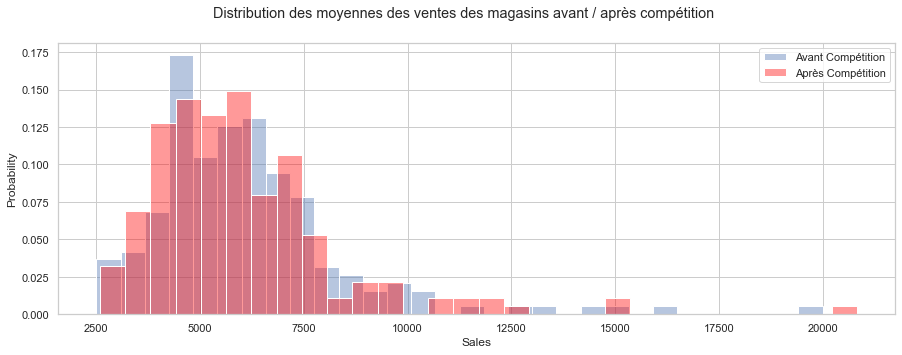

In [112]:
fig, ax = plt.subplots(1, figsize=(15,5))

## Ventes Jours sans promo, superposé jours avec promo
sns.histplot(
    data = subset_comp[subset_comp["BeforeCompetition"]==True],
    x="Sales", 
    bins=30,
    stat = "probability",
    alpha = 0.4,
    label = "Avant Compétition",
    ax = ax
)
sns.histplot(
    data = subset_comp[subset_comp["BeforeCompetition"]==False],
    x="Sales", 
    bins=30,
    stat = "probability",
    color = "red",
    alpha = 0.4,
    label = "Après Compétition",
    ax = ax
)

ax.legend()
fig.suptitle("Distribution des moyennes des ventes des magasins avant / après compétition")
fig.show()

In [113]:
print('Moyenne avant la concurrence', subset_comp[subset_comp["BeforeCompetition"]]["Sales"].mean())
print('Moyenne après la concurrence', subset_comp[~subset_comp["BeforeCompetition"]]["Sales"].mean())

Moyenne avant la concurrence 6157.132587452762
Moyenne après la concurrence 6011.6407532286785


- La distribution des ventes moyennes par jour a **légèrement** été décalée vers la gauche après introduction de la compétition. 
- La différence est faible : en moyenne avant introduction de la compétition, un magasin vend par jour pour 6157 euros et 6011 euros après ouverture de la compétition. 
- **Il serait intéressant d'avoir une évolution temporelle pour chaque store...**

>> <font color='blue'>**Visualisez pour chaque magasin l'impact de l'arrivée d'un concurrent sur les ventes quotidiennes**
</font>

In [114]:
def sales_and_competition(df, store_id, figsize=(15,5)):
    """
    Returns : the temporal evolution of a store sales with the date of beginning of promo2 marked with vertical lime
    """       
    fig, ax = plt.subplots(1, figsize=figsize)

    subset_store = df[df["Store"] == store_id].set_index('Date')
    date_competition = subset_store["CompetitionOpenSince"].values[0]

    subset_store.Sales.plot()
    if date_competition==0:
        print("Pas de date d'ouverture de la compétition pour ce magasin")
    elif date_competition < pd.to_datetime('2013-01-01'):
        print("Date d'ouverture de la compétition avant janvier 2013 : ", date_competition)
    else:
        ax.axvline(
            datetime.date(date_competition.year, date_competition.month, date_competition.day), 
            color='red', 
            label='Début Compétition')

    plt.legend()
    fig.show()

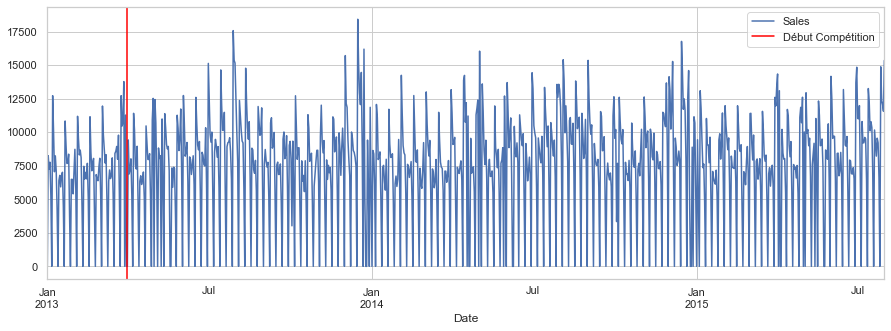

In [115]:
# Modifiez les paramètres et relancer
sales_and_competition(df, 7, figsize=(15,5))

# 3. Sauvegarde du jeu de données

> <font color='blue'> 
- **Sauvegardez le jeu de données suite au différentes transformations / créations de variables.**
- **Remarque** : si vous avez réalisé plusieurs traitements tout au long du notebook, il serait utile pour la suite de *packager* les différentes transformations dans une/plusieurs fonctions.
</font>

In [117]:
try:
    df = df.drop("DatesOfStateHolidays", axis=1)
except:
    print("Colonne déjà supprimée.")

In [120]:
df.to_csv("dataset/data.csv", index=False)